In [ ]:
# Ignore the warnings
import warnings
# warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# System related and data input controls
import os

# Auto reload of library
%reload_ext autoreload
%autoreload 2

# Python path
import sys
base_folder = 'DataScience'
location_base = os.path.join(os.getcwd().split(base_folder)[0], base_folder)
location_module = [os.path.join(location_base, 'Module')] 
for each in location_module:
    if each not in sys.path:
        sys.path.append(each)

from import_KK import *
DeviceStrategy_CPU()
from data_KK import *
from description_KK import *
from preprocessing_KK import *
from preprocessing_text_KK import * ##
from algorithm_textmining_KK import * ##
from evaluation_KK import *
from visualization_KK import *

In [ ]:
def get_data_from_path(folder_location, folder_name=False, concat_axis='row', 
                       reset_index=False, date_column=None):
    # path_folder 하위의 모든 폴더위치와 내부 file 출력
    df = pd.DataFrame()
    print('Getting data from', len(os.listdir(folder_location)), 'folders...')
    for (path, dir, files) in os.walk(folder_location):
#         print(path)
        for file in tqdm(files):
            path_file = os.path.join(path, file)

            ## 데이터 로딩
            if path_file[-4:] == 'xlsx':
                df_sub = pd.read_excel(path_file)
            elif path_file[-3:] == 'csv':
                df_sub = pd.read_csv(path_file)
                
            ### 왓차피디어 변수명변경
            if 'reviewDate' in df_sub.columns:
                df_sub.rename(columns={'year':'date'}, inplace=True)
            elif 'writer' in df_sub.columns:
                df_sub.rename(columns={'writer':'username', 'comment':'review'}, inplace=True)

            ## 키워드 태깅 여부
            if folder_name:
                df_sub['Folder_Name'] = file 
                df_sub['Opening'] = os.path.basename(path).split('(')[1].split(')')[0]
                           
            ## 결합
            if concat_axis == 'col':
                df = pd.concat([df, df_sub], axis=1)
            elif concat_axis == 'row':
                df = pd.concat([df, df_sub], axis=0)
    
    # 정리
    if reset_index:
        df = df.reset_index().iloc[:,1:]
    if date_column != None:
        df[date_column] = pd.to_datetime(df[date_column])
                
    return df

# Hyperparameters

In [1]:
# 데이터 파라미터
TARGET = 'Comment'
CATEGORY = 'Viewing'
# 전처리모델 파라미터
STOPWORDS = ['정보 없음', '없음', '정보', '영화', '너무', '정말', 
             '눈물이', '봤어요', '봤습니다', '하는', '하고', '있는', '없다', 
             '보고', '이렇게', '대한', '보는', '그냥']
NGRAM_RANGE = (1,3)
TFIDF_MAXCOL = 5000
TFIDF_DELLOWFREQ = False
RAY = True
KEYBERT_TOPNKWD = 5
NUM_SHOWKEYWORD = 100
# 영화 필터링
FILTER_MOVIE = ['살인자의 기억법']
# 모델링 파라미터
TOKENIZER = 'KeyBERT'
# euclidean, manhattan, chebyshev, minkowski, canberra, braycurtis, mahalanobis, wminkowski, seuclidean, cosine, correlation
# haversine, hamming, jaccard, dice, russelrao, kulsinski, ll_dirichlet, hellinger, rogerstanimoto, sokalmichener, sokalsneath, yule
UMAP_METRIC = 'euclidean'
UMAP_SEED = 123
NUM_TOPICS = 'auto'

NUM_TOPICWORDS = 10
NUM_TOPICSAMPLES = 5
# 저장
SAVE_LOCAL = True
SAVE_NAME_PREP = 'wordfreq'
SAVE_NAME_LDA = 'Topics_byTokenLDA.xlsx'
SAVE_NAME_BERTopic = 'Topics_byBERTopic.xlsx'

# Data & Preprocessing

In [4]:
# # 데이터
# ## 로딩
# df = get_data_from_path(os.path.join(os.getcwd(), 'Data_Raw'), folder_name=True, concat_axis='row', 
#                         reset_index=True, date_column=None)
# ## 변수명 변환
# df.rename(columns={'Folder_Name':'Movie', 'username':'User', 'date':'Viewing', 'review':'Comment', 'rating':'Rating', 
#                    'likes':'Like', 'dislikes':'Dislike'}, inplace=True)
# ## 전처리
# df.Viewing = df.Viewing.apply(lambda x: str(x)[:4])
# df['Source'] = df.Movie.apply(lambda x: x.split('(')[1].split(')')[0])
# df.Source.replace({'네티즌':'Naver(Netizen)', '실관람객':'Naver(Audience)'}, inplace=True)
# df.Source = df.Source.apply(lambda x: 'Watcha' if len(x) == 4 else x)
# df.Movie = df.Movie.apply(lambda x: x.split('(')[0])
# df['Rating'] = df['Rating'].fillna('-1')
# df['Rating'] = df['Rating'].apply(lambda x: '-1' if x == '보고싶어요' else x)
# df['Rating'] = df['Rating'].apply(lambda x: '-1' if x == '보는 중' else x)
# df['Rating'] = df['Rating'].apply(lambda x: '-1' if x == '[]' else x)
# df['Rating'] = df['Rating'].apply(lambda x: float(x))
# df['Like'] = df['Like'].fillna('-1')
# df['Like'] = df['Like'].apply(lambda x: '-1' if x == '[]' else x)
# df['Like'] = df['Like'].apply(lambda x: int(str(x).replace(',','')))
# df['Dislike'] = df['Dislike'].fillna('-1')
# df['Dislike'] = df['Dislike'].apply(lambda x: int(x))
# df['Viewing'] = df['Viewing'].apply(lambda x: '-1' if x == '[]' else x)
# df['Viewing'] = df['Viewing'].apply(lambda x: 2024 if x in ['4시간 ', '5시간 ', '6시간 ', '7시간 ',
#                                                              '8시간 ', '9시간 ', '10시간', '16시간', 
#                                                              '18시간', '20시간', '24시간', '23시간'] else x)
# ## 삭제
# df.drop(columns=['url', 'reviewDate'], inplace=True)
# ## 결측치처리
# df_sub = df[~df.Like.isnull()].fillna(0)
# df = df.combine_first(df_sub)
# ## 정리
# df = df[['Movie', 'Opening', 'Source', 'User', 'Viewing', 'Rating', 'Like', 'Dislike', 'Comment']]
# ## 무의견 삭제
# df.dropna(subset=[TARGET], inplace=True)
# df = df[df[TARGET] != '']
# ## 중복 삭제
# df = df.drop_duplicates(keep='first').reset_index().iloc[:,1:]
# ## 텍스트 전처리
# df[TARGET+'_Prep'] = df[TARGET].progress_apply(lambda x: text_preprocessor(x, del_number=False, 
#                                                                            del_bracket_content=False,
#                                                                            stop_words=STOPWORDS))
# ## 정리
# df.dropna(subset=[TARGET+'_Prep'], inplace=True)
# df = df[df[TARGET+'_Prep'] != '']
# df = df[df[TARGET+'_Prep'] != 'nan']
# df = df.reset_index().iloc[:,1:]
# df.to_csv(os.path.join(os.getcwd(), 'Data', 'df_movie.csv'), index=False, encoding='utf-8-sig')

In [27]:
## 단어빈도 추출과 변환
if FILTER_MOVIE != []:
    ## 기초전처리 완료데이터 로딩
    df = pd.read_csv(os.path.join(os.getcwd(), 'Data', 'df_movie.csv'), encoding='utf-8-sig')
    df = df[~df.Movie.isin(FILTER_MOVIE)].reset_index().iloc[:,1:]
    
    # word_freq, wordadj_freq, df_freq = preprocessing_wordfreq(df, colname_target=TARGET+'_Prep', colname_category=None, 
    #                                                           ngram_range=NGRAM_RANGE,
    #                                                           tfidf_maxcol=TFIDF_MAXCOL, tfidf_dellowfreq=TFIDF_DELLOWFREQ,
    #                                                           keybert_topnkwd=KEYBERT_TOPNKWD,
    #                                                           sent2kwd_ray=RAY,
    #                                                           num_showkeyword=NUM_SHOWKEYWORD, 
    #                                                           save_local=SAVE_LOCAL, save_name=SAVE_NAME_PREP)
    # df_freq.to_csv(os.path.join(os.getcwd(), 'Data', 'df_moviefilter_prep_(1,3).csv'), index=False, encoding='utf-8-sig')
    
    word_freq_categ, wordadj_freq_categ, df_freq_categ = preprocessing_wordfreq(df, colname_target=TARGET+'_Prep', colname_category=CATEGORY,
                                                                    ngram_range=NGRAM_RANGE,
                                                                    tfidf_maxcol=TFIDF_MAXCOL, tfidf_dellowfreq=TFIDF_DELLOWFREQ,
                                                                    keybert_topnkwd=KEYBERT_TOPNKWD,
                                                                    sent2kwd_ray=RAY,
                                                                    num_showkeyword=NUM_SHOWKEYWORD, 
                                                                    save_local=SAVE_LOCAL, save_name=SAVE_NAME_PREP)
    df_freq_categ.to_csv(os.path.join(os.getcwd(), 'Data', 'df_moviefilter_prepcateg_(1,3).csv'), index=False, encoding='utf-8-sig')
else:
    ## 기초전처리 완료데이터 로딩
    df = pd.read_csv(os.path.join(os.getcwd(), 'Data', 'df_movie.csv'), encoding='utf-8-sig')

    # word_freq, wordadj_freq, df_freq = preprocessing_wordfreq(df, colname_target=TARGET+'_Prep', colname_category=None, 
    #                                                           ngram_range=NGRAM_RANGE,
    #                                                           tfidf_maxcol=TFIDF_MAXCOL, tfidf_dellowfreq=TFIDF_DELLOWFREQ,
    #                                                           keybert_topnkwd=KEYBERT_TOPNKWD,
    #                                                           sent2kwd_ray=RAY,
    #                                                           num_showkeyword=NUM_SHOWKEYWORD, 
    #                                                           save_local=SAVE_LOCAL, save_name=SAVE_NAME_PREP)
    # df_freq.to_csv(os.path.join(os.getcwd(), 'Data', 'df_movie_prep_(1,3).csv'), index=False, encoding='utf-8-sig')
    
    word_freq_categ, wordadj_freq_categ, df_freq_categ = preprocessing_wordfreq(df, colname_target=TARGET+'_Prep', colname_category=CATEGORY,
                                                                    ngram_range=NGRAM_RANGE,
                                                                    tfidf_maxcol=TFIDF_MAXCOL, tfidf_dellowfreq=TFIDF_DELLOWFREQ,
                                                                    keybert_topnkwd=KEYBERT_TOPNKWD,
                                                                    sent2kwd_ray=RAY,
                                                                    num_showkeyword=NUM_SHOWKEYWORD, 
                                                                    save_local=SAVE_LOCAL, save_name=SAVE_NAME_PREP)
    df_freq_categ.to_csv(os.path.join(os.getcwd(), 'Data', 'df_movie_prepcateg_(1,3).csv'), index=False, encoding='utf-8-sig')

  0%|                                                                                           | 0/22 [00:00<?, ?it/s]

training was done. used memory 1.515 Gb1.515 Gb
all cohesion probabilities was computed. # words = 0
all branching entropies was computed # words = 0
all accessor variety was computed # words = 0
C:/Users/KK/anaconda3/Lib/site-packages/soynlp
cannot access local variable 'f' where it is not associated with a value
cannot access local variable 'f' where it is not associated with a value
before postprocessing 0
_noun_scores_ 0
after postprocessing 0


  5%|███▊                                                                               | 1/22 [00:03<01:03,  3.04s/it]

training was done. used memory 1.712 Gb1.712 Gb
all cohesion probabilities was computed. # words = 0
all branching entropies was computed # words = 0
all accessor variety was computed # words = 0
C:/Users/KK/anaconda3/Lib/site-packages/soynlp
cannot access local variable 'f' where it is not associated with a value
cannot access local variable 'f' where it is not associated with a value
before postprocessing 0
_noun_scores_ 0
after postprocessing 0


  9%|███████▌                                                                           | 2/22 [00:05<00:57,  2.89s/it]

training was done. used memory 1.885 Gb 1.885 Gb
all cohesion probabilities was computed. # words = 0
all branching entropies was computed # words = 0
all accessor variety was computed # words = 0
C:/Users/KK/anaconda3/Lib/site-packages/soynlp
cannot access local variable 'f' where it is not associated with a value
cannot access local variable 'f' where it is not associated with a value
before postprocessing 0
_noun_scores_ 0
after postprocessing 0


 14%|███████████▎                                                                       | 3/22 [00:09<01:04,  3.40s/it]

training was done. used memory 2.041 Gby 2.041 Gb
all cohesion probabilities was computed. # words = 26
all branching entropies was computed # words = 98
all accessor variety was computed # words = 98
C:/Users/KK/anaconda3/Lib/site-packages/soynlp
cannot access local variable 'f' where it is not associated with a value
cannot access local variable 'f' where it is not associated with a value
before postprocessing 56
_noun_scores_ 24
after postprocessing 12


 18%|███████████████                                                                    | 4/22 [00:24<02:24,  8.01s/it]

training was done. used memory 1.906 Gby 1.906 Gb
all cohesion probabilities was computed. # words = 49
all branching entropies was computed # words = 165
all accessor variety was computed # words = 165
C:/Users/KK/anaconda3/Lib/site-packages/soynlp
cannot access local variable 'f' where it is not associated with a value
cannot access local variable 'f' where it is not associated with a value
before postprocessing 86
_noun_scores_ 38
after postprocessing 20


 23%|██████████████████▊                                                                | 5/22 [00:47<03:43, 13.14s/it]

training was done. used memory 2.087 Gby 2.087 Gb
all cohesion probabilities was computed. # words = 26
all branching entropies was computed # words = 134
all accessor variety was computed # words = 134
C:/Users/KK/anaconda3/Lib/site-packages/soynlp
cannot access local variable 'f' where it is not associated with a value
cannot access local variable 'f' where it is not associated with a value
before postprocessing 57
_noun_scores_ 27
after postprocessing 16


 27%|██████████████████████▋                                                            | 6/22 [01:04<03:55, 14.71s/it]

training was done. used memory 2.093 Gb
all cohesion probabilities was computed. # words = 6
all branching entropies was computed # words = 41
all accessor variety was computed # words = 41
C:/Users/KK/anaconda3/Lib/site-packages/soynlp
cannot access local variable 'f' where it is not associated with a value
cannot access local variable 'f' where it is not associated with a value
before postprocessing 20
_noun_scores_ 12
after postprocessing 5


 32%|██████████████████████████▍                                                        | 7/22 [01:14<03:17, 13.14s/it]

training was done. used memory 2.097 Gby 2.097 Gb
all cohesion probabilities was computed. # words = 34
all branching entropies was computed # words = 152
all accessor variety was computed # words = 152
C:/Users/KK/anaconda3/Lib/site-packages/soynlp
cannot access local variable 'f' where it is not associated with a value
cannot access local variable 'f' where it is not associated with a value
before postprocessing 56
_noun_scores_ 23
after postprocessing 14


 36%|██████████████████████████████▏                                                    | 8/22 [01:32<03:24, 14.58s/it]

training was done. used memory 2.104 Gby 2.104 Gb
all cohesion probabilities was computed. # words = 71
all branching entropies was computed # words = 184
all accessor variety was computed # words = 184
C:/Users/KK/anaconda3/Lib/site-packages/soynlp
cannot access local variable 'f' where it is not associated with a value
cannot access local variable 'f' where it is not associated with a value
before postprocessing 102
_noun_scores_ 38
after postprocessing 27


 41%|█████████████████████████████████▉                                                 | 9/22 [01:57<03:50, 17.76s/it]

training was done. used memory 2.109 Gby 2.109 Gb
all cohesion probabilities was computed. # words = 78
all branching entropies was computed # words = 255
all accessor variety was computed # words = 255
C:/Users/KK/anaconda3/Lib/site-packages/soynlp
cannot access local variable 'f' where it is not associated with a value
cannot access local variable 'f' where it is not associated with a value
before postprocessing 147
_noun_scores_ 47
after postprocessing 30


 45%|█████████████████████████████████████▎                                            | 10/22 [02:26<04:16, 21.38s/it]

training was done. used memory 2.329 Gbry 2.326 Gb
all cohesion probabilities was computed. # words = 982
all branching entropies was computed # words = 1729
all accessor variety was computed # words = 1729
C:/Users/KK/anaconda3/Lib/site-packages/soynlp
cannot access local variable 'f' where it is not associated with a value
cannot access local variable 'f' where it is not associated with a value
before postprocessing 1250
_noun_scores_ 342
after postprocessing 204


 50%|█████████████████████████████████████████                                         | 11/22 [05:35<13:17, 72.47s/it]

training was done. used memory 2.539 Gbry 2.536 Gb
all cohesion probabilities was computed. # words = 2782
all branching entropies was computed # words = 4151
all accessor variety was computed # words = 4151
C:/Users/KK/anaconda3/Lib/site-packages/soynlp
cannot access local variable 'f' where it is not associated with a value
cannot access local variable 'f' where it is not associated with a value
before postprocessing 3427
_noun_scores_ 990
after postprocessing 572


 55%|████████████████████████████████████████████▏                                    | 12/22 [13:56<33:50, 203.02s/it]

training was done. used memory 1.908 Gbory 1.888 Gb
all cohesion probabilities was computed. # words = 10368
all branching entropies was computed # words = 14416
all accessor variety was computed # words = 14416
C:/Users/KK/anaconda3/Lib/site-packages/soynlp
cannot access local variable 'f' where it is not associated with a value
cannot access local variable 'f' where it is not associated with a value
before postprocessing 11387
_noun_scores_ 2685
after postprocessing 1502


 59%|██████████████████████████████████████████████▋                                | 13/22 [50:16<2:00:17, 801.95s/it]

training was done. used memory 2.129 Gbry 2.129 Gb
all cohesion probabilities was computed. # words = 3846
all branching entropies was computed # words = 5925
all accessor variety was computed # words = 5925
C:/Users/KK/anaconda3/Lib/site-packages/soynlp
cannot access local variable 'f' where it is not associated with a value
cannot access local variable 'f' where it is not associated with a value
before postprocessing 4705
_noun_scores_ 1209
after postprocessing 688


 64%|█████████████████████████████████████████████████                            | 14/22 [1:01:00<1:40:32, 754.02s/it]

training was done. used memory 2.109 Gbry 2.108 Gb
all cohesion probabilities was computed. # words = 3366
all branching entropies was computed # words = 5286
all accessor variety was computed # words = 5286
C:/Users/KK/anaconda3/Lib/site-packages/soynlp
cannot access local variable 'f' where it is not associated with a value
cannot access local variable 'f' where it is not associated with a value
before postprocessing 4215
_noun_scores_ 1157
after postprocessing 690


 68%|████████████████████████████████████████████████████▍                        | 15/22 [1:10:19<1:21:07, 695.33s/it]

training was done. used memory 2.105 Gbry 2.105 Gb
all cohesion probabilities was computed. # words = 4724
all branching entropies was computed # words = 7019
all accessor variety was computed # words = 7019
C:/Users/KK/anaconda3/Lib/site-packages/soynlp
cannot access local variable 'f' where it is not associated with a value
cannot access local variable 'f' where it is not associated with a value
before postprocessing 5639
_noun_scores_ 1485
after postprocessing 875


 73%|████████████████████████████████████████████████████████                     | 16/22 [1:23:20<1:12:07, 721.29s/it]

training was done. used memory 2.116 Gbry 2.116 Gb
all cohesion probabilities was computed. # words = 5590
all branching entropies was computed # words = 8094
all accessor variety was computed # words = 8094
C:/Users/KK/anaconda3/Lib/site-packages/soynlp
cannot access local variable 'f' where it is not associated with a value
cannot access local variable 'f' where it is not associated with a value
before postprocessing 6566
_noun_scores_ 1680
after postprocessing 968


 77%|███████████████████████████████████████████████████████████▌                 | 17/22 [1:39:20<1:06:04, 792.89s/it]

training was done. used memory 2.141 Gbry 2.141 Gb
all cohesion probabilities was computed. # words = 8436
all branching entropies was computed # words = 12184
all accessor variety was computed # words = 12184
C:/Users/KK/anaconda3/Lib/site-packages/soynlp
cannot access local variable 'f' where it is not associated with a value
cannot access local variable 'f' where it is not associated with a value
before postprocessing 9802
_noun_scores_ 2491
after postprocessing 1436


 82%|██████████████████████████████████████████████████████████████▏             | 18/22 [2:04:38<1:07:22, 1010.75s/it]

training was done. used memory 2.196 Gbry 2.196 Gb
all cohesion probabilities was computed. # words = 6981
all branching entropies was computed # words = 10091
all accessor variety was computed # words = 10091
C:/Users/KK/anaconda3/Lib/site-packages/soynlp
cannot access local variable 'f' where it is not associated with a value
cannot access local variable 'f' where it is not associated with a value
before postprocessing 8027
_noun_scores_ 2014
after postprocessing 1172


 86%|███████████████████████████████████████████████████████████████████▎          | 19/22 [2:25:32<54:11, 1083.99s/it]

training was done. used memory 2.179 Gbry 2.179 Gb
all cohesion probabilities was computed. # words = 4536
all branching entropies was computed # words = 7029
all accessor variety was computed # words = 7029
C:/Users/KK/anaconda3/Lib/site-packages/soynlp
cannot access local variable 'f' where it is not associated with a value
cannot access local variable 'f' where it is not associated with a value
before postprocessing 5344
_noun_scores_ 1382
after postprocessing 832


 91%|███████████████████████████████████████████████████████████████████████▊       | 20/22 [2:38:54<33:18, 999.27s/it]

training was done. used memory 2.144 Gbry 2.144 Gb
all cohesion probabilities was computed. # words = 3083
all branching entropies was computed # words = 5169
all accessor variety was computed # words = 5169
C:/Users/KK/anaconda3/Lib/site-packages/soynlp
cannot access local variable 'f' where it is not associated with a value
cannot access local variable 'f' where it is not associated with a value
before postprocessing 3700
_noun_scores_ 1010
after postprocessing 583


 95%|███████████████████████████████████████████████████████████████████████████▍   | 21/22 [2:47:25<14:12, 852.71s/it]

training was done. used memory 2.127 Gbry 2.127 Gb
all cohesion probabilities was computed. # words = 5530
all branching entropies was computed # words = 8775
all accessor variety was computed # words = 8775
C:/Users/KK/anaconda3/Lib/site-packages/soynlp
cannot access local variable 'f' where it is not associated with a value
cannot access local variable 'f' where it is not associated with a value
before postprocessing 6669
_noun_scores_ 1768
after postprocessing 1001



00%|███████████████████████████████████████████████████████████████████████████████| 22/22 [3:03:46<00:00, 501.19s/it]

Saving...: 2025-02-06 19:32:05.898662
Sentence to Keywords...: 2025-02-06 19:32:06.395598


2025-02-06 19:32:07,270	INFO worker.py:1619 -- Calling ray.init() again after it has already been called.
2025-02-06 19:33:15,202	INFO worker.py:1777 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
2025-02-06 19:56:13,260	INFO worker.py:1777 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


Results Concat!: 2025-02-06 21:32:29.350695


Token by SoyNLP  Token by TF-IDF  Token by KeyBERT  \
Length             2718            72257            250358   

        Token(ADJ) by SoyNLP  Token(ADJ) by TF-IDF  Token(ADJ) by KeyBERT  
Length                 33501                 78544                   5213

category word  score category        word  score category  \
0          2007   영화     18     2003         감동이 0.0000     2003   
1          2007  마지막     16     2003      감동이 남는 0.0000     2003   
2          2007   일본      7     2003  감동이 남는 따스한 0.0000     2003   
3          2011   사랑     19     2003          남는 0.0000     2003   
4          2011   가슴     16     2003      남는 따스한 0.0000     2003   
...         ...  ...    ...      ...         ...    ...      ...   
250353      NaN  NaN    NaN      NaN         NaN    NaN     2024   
250354      NaN  NaN    NaN      NaN         NaN    NaN     2024   
250355      NaN  NaN    NaN      NaN         NaN    NaN     2024   
250356      NaN  NaN    NaN      NaN         NaN    NaN     2024   
250357      NaN  NaN    NaN      NaN         NaN    NaN     2024   

                  word  score  
0       잔잔하지만 오래도록 감동이      0  
1           잔잔하지만 오래도록      0  
2          오래도록 감동이 남는      0  
3          남는 따스한 영화강추      0  
4                잔잔하지만      0  
...                ...    ...  
250353        딸에관한 이야기      0  
250354         많은걸 느끼게      0  
250355        옛추억대로좋았다      0  
250356           답이없구만      0  
250357             많은걸      0  

[250358 rows x 9 columns]

category      word  score category        word  score category  \
0         2007  마지막_사에키의 1.0000     2003      감동이_남는      1     2003   
1         2007   마지막_장면은 1.0000     2003    감동이_오래도록      1     2004   
2         2007   일본_영화보고 1.0000     2003      남는_감동이      1     2004   
3         2007    일본_첨으로 1.0000     2003      남는_따스한      1     2004   
4         2011    사랑_따뜻한 1.0000     2003      따스한_남는      1     2005   
...        ...       ...    ...      ...         ...    ...      ...   
78539      NaN       NaN    NaN     2024     이야기가_되어      1      NaN   
78540      NaN       NaN    NaN     2024    이야기가_삽입된      1      NaN   
78541      NaN       NaN    NaN     2024     이야기가_뻗어      1      NaN   
78542      NaN       NaN    NaN     2024  이야기가_대한모두에      1      NaN   
78543      NaN       NaN    NaN     2024   이야기가_상관없는      1      NaN   

                      word  score  
0               잔잔하지만_오래도록 1.0000  
1                여자주인공이_왠지 1.0000  
2              정도다너무도_감동적인 1.0000  
3                정도다너무도_끼칠 1.0000  
4      로버트의환자연기와_로빈의따뜻한연기는 1.0000  
...                    ...    ...  
78539                  NaN    NaN  
78540                  NaN    NaN  
78541                  NaN    NaN  
78542                  NaN    NaN  
78543                  NaN    NaN  

[78544 rows x 9 columns]

ValueError: Length mismatch: Expected axis has 9 elements, new values have 2 elements

In [2]:
word_freq_categ, wordadj_freq_categ, df_freq_categ = preprocessing_wordfreq(df.iloc[:500,:], colname_target=TARGET+'_Prep', colname_category=[],
                                                                    ngram_range=NGRAM_RANGE,
                                                                    tfidf_maxcol=TFIDF_MAXCOL, tfidf_dellowfreq=TFIDF_DELLOWFREQ,
                                                                    keybert_topnkwd=KEYBERT_TOPNKWD,
                                                                    sent2kwd_ray=RAY,
                                                                    num_showkeyword=NUM_SHOWKEYWORD, 
                                                                    save_local=False, save_name=SAVE_NAME_PREP)
# df_freq_categ.to_csv(os.path.join(os.getcwd(), 'Data', 'df_movie_prepcateg_(1,3).csv'), index=False, encoding='utf-8-sig')

NameError: name 'preprocessing_wordfreq' is not defined

# Modeling

## LDA

- Latent Dirichlet Allocation (LDA)는 토픽모델링에 이용되는 대표적인 알고리즘

> - 토픽 모델링이 제공하는 토픽은 어떤 주제를 구성하는 단어들인지로 정의되며,
> - 문서 집합에서 이 단어 집합을 찾아 우리의 문서가 어떤 토픽인지 알 수 있음

- LDA 모델을 학습하기 전에 몇 개의 토픽으로 나눌 것인지 먼저 결정해야 함

> - 일반적으로 (1) perplexity와 coherence를 함께 고려하여 결정 + (2) 정성적인 토픽 갯수 고려하여 결정
>> - perplexity: 모델이 얼마나 잘 예측하는지 나타내는 지표로, 낮은 perplexity 값은 모델이 문서에서 나타나는 단어를 더 잘 예측한다는 것을 의미
>> - coherence: 발견된 토픽이 얼마나 의미있는지 나타내는 지표로, 높은 coherence 값은 토픽 내 단어들이 서로 관련성이 높다는 것을 의미

- LDAvis

> (1) Intertopic Distance Map (via multidimensional scaling)
> - 각 토픽이 가진 고차원의 단어들을 PCA로 2차원 축소 시각화
> - 원크기: 토픽의 단어들이 얼마나 포함 및 분포되어 있는지
> - 원거리: 토픽간의 유사성 (2개의 원이 겹친다면 유사한 토픽이라는 의미)
>
> (2) Top-30 Most Relevant Terms for Topic
> - 토픽 별로 가장 자주 등장하는 단어들(람디=1)과 토픽 간 차이가 많이나는 단어들(람다=0)을 종합적으로 고려 

In [4]:
if FILTER_MOVIE != []:
    df_freq = pd.read_csv(os.path.join(os.getcwd(), 'Data', 'df_moviefilter_prep_(1,3).csv'), encoding='utf-8-sig')
    df_freq_categ = pd.read_csv(os.path.join(os.getcwd(), 'Data', 'df_moviefilter_prepcateg_(1,3).csv'), encoding='utf-8-sig')
    word_freq = pd.read_csv(os.path.join(os.getcwd(), 'Result', 'WordFreq', 'Filter', 'wordfreq_total.csv'), encoding='utf-8-sig')
    wordadj_freq = pd.read_csv(os.path.join(os.getcwd(), 'Result', 'WordFreq', 'Filter', 'wordfreq_totaladj.csv'), encoding='utf-8-sig')
    word_freq_categ = pd.read_csv(os.path.join(os.getcwd(), 'Result', 'WordFreq', 'Filter', 'wordfreqcateg_total.csv'), encoding='utf-8-sig')
    wordadj_freq_categ = pd.read_csv(os.path.join(os.getcwd(), 'Result', 'WordFreq', 'Filter', 'wordfreqcateg_totaladj.csv'), encoding='utf-8-sig')
else:
    df_freq = pd.read_csv(os.path.join(os.getcwd(), 'Data', 'df_movie_prep_(1,3).csv'), encoding='utf-8-sig')
    df_freq_categ = pd.read_csv(os.path.join(os.getcwd(), 'Data', 'df_movie_prepcateg_(1,3).csv'), encoding='utf-8-sig')
    word_freq = pd.read_csv(os.path.join(os.getcwd(), 'Result', 'WordFreq', 'Total', 'wordfreq_total.csv'), encoding='utf-8-sig')
    wordadj_freq = pd.read_csv(os.path.join(os.getcwd(), 'Result', 'WordFreq', 'Total', 'wordfreq_totaladj.csv'), encoding='utf-8-sig')
    word_freq_categ = pd.read_csv(os.path.join(os.getcwd(), 'Result', 'WordFreq', 'Total', 'wordfreqcateg_total.csv'), encoding='utf-8-sig')
    wordadj_freq_categ = pd.read_csv(os.path.join(os.getcwd(), 'Result', 'WordFreq', 'Total', 'wordfreqcateg_totaladj.csv'), encoding='utf-8-sig')

2025-02-03 22:24:55,039	INFO worker.py:1619 -- Calling ray.init() again after it has already been called.


Optimal Topic Number:  2


Related Keywords  \
Topic 1  '연기(22.5%)', '감동(20.2%)', '눈물(11.0%)', '서현진(9.2%)', '연기가(8.7%)', '반전(8.1%)', '진짜(5.8%)', '좋은(5.2...   
Topic 2  '사랑(28.6%)', '가족(11.1%)', '치매(9.5%)', '이야기(8.7%)', '지는(7.9%)', '기억(7.1%)', '가는(7.1%)', '마음(7.1%)...   

         Number of Sentences  Percentage  
Topic 1                30987      0.5096  
Topic 2                29816      0.4904

Topic Number  Weight  \
9871       Topic 1  0.9781   
46512      Topic 1  0.9764   
60400      Topic 1  0.9747   
47059      Topic 1  0.9745   
60627      Topic 1  0.9734   
41215      Topic 2  0.9985   
35255      Topic 2  0.9956   
40972      Topic 2  0.9947   
40940      Topic 2  0.9946   
40897      Topic 2  0.9945   

                                                                                                   Comment  
9871   레이첼 맥아담스 최고… 짱짱 캡짱… 레이첼 최고… 지존공쥬 맥아담스 최고… 이 영화는 레이첼 맥아담스가 나온다는 점에서 이미 명작이다… 게다가 레이첼이 온갖 폭풍같은 감정들...  
46512  스토리도 괜찮고 배우들의 연기도 좋습니다. 이 영화를 보는 내내 부모님 생각이 나더라구요. 정말 슬펐습니다. 이 영화를 보시면 아마 부모님 생각이 많이 나실겁니다. 진짜 이...  
60400  안성기 배우님과 서현진 배우님 연기도 그렇고 다른 연기자분들 연기도 너무 좋았어요 같이 보시는 관람객분들도 다들 훌쩍 거리시더라구요 .. 물론 저도 광광 울었습니다 …. 너...  
47059  사실 엑소 찬열이 나온다거 해서 본 영화였지만 영화를 보면서 가족들과 함께 보았으면 정말 좋았을 영화라고 생각했다. 배우님들의 연기도 최고였으며 마지막 반전도 최고였다. 영...  
60627  진짜 왜 흥행 안한건지 모르겠음 원래부터 서현진 배우님 팬이라서 이번 영화도 물론 기대 하고 봤지만 기대 이상으로 감동적이고 무엇보다 서현진배우님 연기에 한번 더 놀라고 감...  
41215  구원의 시작  미자. 말 그대로 아름다운 사람. 그는 시로써, 그리고 그 자체로 시로서 살아간 사람이다. 화사한 옷, 꽃을 좋아하는 취향, 멋쩍은 웃음, 모두 그의 아름다움...  
35255  내 미래를 현재를 과거를 한 순간에 무너뜨리고 결국엔 내 자신마저 앗아갈 그것을 인정하고 받아들이고 공존하기 위해 노력하는 아직은 앨리스로 남기 위한, 여전히 앨리스인, 알...  
40972  시는 나의 이야기다. ‘나’를 버릴 때 ‘시’는 완성된다.  (스포일러)  감독은 ‘시’란 ‘한 인간의 이야기’일 뿐이라 생각하며, 시를 쓰려면 ‘대상의 외면과 아름다움을 ...  
40940  한 소녀가 물에 불어터진 채 강가에 둥둥 떠내려 왔다. 그맘때쯤, 그녀는 생각했다. 시를 써야겠다고. 그녀는 시를 배우기 시작했다. 뭐든지 시작은 어려운 법이었다. 자그만 ...  
40897  시를 배우기 전의 미자는 말이 많다. 하지만 시 구절을 적으면서 미자는 말이 줄어든다. 시인은 시의 본질을 ‘아름다움에 다가가는 것’이라고 말했다.미자는 주변의 사물의 미를...

Comment  \
0                            배우들 연기가 어색하게 보이는 것은  배우들 문제가 아니다. 이야기 흐름이 자연스럽지 않은것이 단번에 느껴진다. 감독의 실수가 너무 크다.   
1                                                                                         살아남은 보단 남겨진 이들에게   
2      국악을 알리는건 좋은데 왤케 피곤하지... 쓸데없는 장면 너무많고 필요없는연출너무많고 연기력은 너무부족하고 최악의 영화에 시간을 왤케 길고 보는게 진짜 고역이었다 지금세대가...   
3      “어이가리”의 어이에는 세가지 정도의 뜻이 있다. 첫째는 “왜?”의 어이이고, 둘째는 ”어떻게“의 어이이며, 셋째는 ”어디를“의 어이이다. 영화에는 이 세가지 의미가 다 담...   
4                               실제 비슷한 생활을 해본 입장에서 조금은 어설프기도 한 공감하기 힘든 지루한 진행. 자꾸 그걸 느끼라고 하는데  자꾸 안 느껴지는..   
...                                                                                                    ...   
60798     개봉관이 없어서 거재도 예술영화 상영관까지 가서 관람을 했었습니다.먼 길을 달려서 볼 충분한 가치가 있는 영화!여자친구와 함께 웃고 눈물흘리게 했던 장면들이 기억에 남네요.   
60799                                         재미있다 재미없다보다는 느끼며 봐야 진실성을 느끼는 영화!!보고난후 나의 한마디는.... 정말 아름답다!!!   
60800                                                                                          생각했던거보다볼만해요   
60801                                                                      기대를 많이 해서그런가 생각보다는 별로네요 감동도 그다지   
60802                                                                     비슷한 내용이 여러 번 반복되어 다소 지루한 감이 있었다.   

       Related Topic  Weight                  Each Topic Weights  
0                  1  0.5576    [(0, 0.5576403), (1, 0.4423597)]  
1                  2  0.7997  [(0, 0.20027305), (1, 0.79972696)]  
2                  1  0.6868   [(0, 0.6868037), (1, 0.31319627)]  
3                  2  0.6687   [(0, 0.33130002), (1, 0.6686999)]  
4                  2  0.7880   [(0, 0.21200661), (1, 0.7879934)]  
...              ...     ...                                 ...  
60798              1  0.8077   [(0, 0.8076782), (1, 0.19232178)]  
60799              2  0.6136   [(0, 0.38641962), (1, 0.6135804)]  
60800              1  0.7497  [(0, 0.74967265), (1, 0.25032738)]  
60801              1  0.9357    [(0, 0.935689), (1, 0.06431103)]  
60802              1  0.8484   [(0, 0.8483566), (1, 0.15164346)]  

[60803 rows x 4 columns]

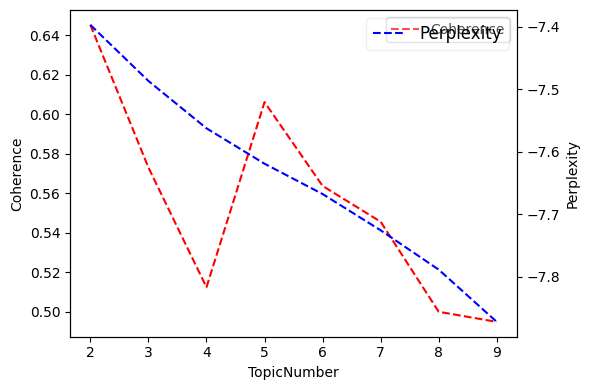

In [7]:
# # 원래의견 기준 LDA
# save_name = SAVE_NAME_LDA.split('.')[0]+'_CommentAuto(1,3).xlsx'

# topic_kw_LDA, topic_doc_LDA, \
# doc_topic_LDA, model_LDA = modeling_LDA(df_freq['Token_'+TOKENIZER], df_freq['Comment'],
#                                         num_topics=NUM_TOPICS, num_topicwords=NUM_TOPICWORDS, num_topicsamples=NUM_TOPICSAMPLES,
#                                         save_local=SAVE_LOCAL, save_name=save_name)
# display(topic_kw_LDA, topic_doc_LDA, doc_topic_LDA)

In [5]:
# 기초전처리의견 기준 LDA
for i in range(2,11):
    save_name = SAVE_NAME_LDA.split('.')[0]+'_CommentPrepAuto(1,3)_Topic{}.xlsx'.format(i)

    topic_kw_LDA, topic_doc_LDA, \
    doc_topic_LDA, model_LDA = modeling_LDA(df_freq['Token_'+TOKENIZER], df_freq['Comment_Prep'],
                                            num_topics=i, num_topicwords=NUM_TOPICWORDS, num_topicsamples=NUM_TOPICSAMPLES,
                                            save_local=SAVE_LOCAL, save_name=save_name)
    display(topic_kw_LDA)

Related Keywords  \
Topic 1  '연기(22.5%)', '감동(20.2%)', '눈물(11.0%)', '서현진(9.2%)', '연기가(8.7%)', '반전(8.1%)', '진짜(5.8%)', '좋은(5.2...   
Topic 2  '사랑(28.6%)', '가족(11.1%)', '치매(9.5%)', '이야기(8.7%)', '지는(7.9%)', '기억(7.1%)', '가는(7.1%)', '마음(7.1%)...   

         Number of Sentences  Percentage  
Topic 1                30987      0.5096  
Topic 2                29816      0.4904

Related Keywords  \
Topic 1  '눈물(14.8%)', '연기(12.3%)', '엄마(9.8%)', '진짜(9.8%)', '많이(9.8%)', '좋은(9.0%)', '최고(9.0%)', '좋았어요(9.0%...   
Topic 2  '사랑(30.0%)', '가족(9.3%)', '이야기(9.3%)', '치매(8.6%)', '지는(8.6%)', '기억(7.9%)', '가는(7.1%)', '가슴(7.1%)'...   
Topic 3  '감동(27.5%)', '연기(21.6%)', '반전(10.3%)', '연기가(10.3%)', '서현진(8.4%)', '배우들의(5.1%)', '눈물(5.1%)', '스토리...   

         Number of Sentences  Percentage  
Topic 1                20162      0.3316  
Topic 2                24845      0.4086  
Topic 3                15796      0.2598

Related Keywords  \
Topic 1  '연기(28.3%)', '서현진(10.1%)', '눈물(9.4%)', '연기가(8.2%)', '최고(8.2%)', '진짜(7.5%)', '좋은(7.5%)', '좋았어요(7....   
Topic 2  '사랑(27.9%)', '가족(11.7%)', '치매(9.7%)', '이야기(9.1%)', '기억(8.4%)', '지는(7.8%)', '가는(7.1%)', '알츠하이머(6....   
Topic 3  '감동(37.3%)', '연기(10.4%)', '엄마(10.0%)', '눈물(9.6%)', '반전(8.5%)', '연기가(6.5%)', '좋았습니다(5.0%)', '영화입니...   
Topic 4  '남자(13.0%)', '카시오페아(13.0%)', '사랑(13.0%)', '말이(9.8%)', '슬퍼요(9.8%)', '인생(8.7%)', '여자(8.7%)', '내가(8...   

         Number of Sentences  Percentage  
Topic 1                19277      0.3170  
Topic 2                21682      0.3566  
Topic 3                11825      0.1945  
Topic 4                 8019      0.1319

Related Keywords  \
Topic 1  '엄마(25.8%)', '아버지(12.5%)', '반전이(10.8%)', '재밌게(8.3%)', '사랑(8.3%)', '눈물(7.5%)', '있어(7.5%)', '연기(6....   
Topic 2  '사랑(26.1%)', '이야기(11.1%)', '가족(10.6%)', '치매(10.0%)', '기억(8.9%)', '가는(7.8%)', '지는(7.8%)', '알츠하이머(...   
Topic 3  '감동(28.5%)', '연기(24.8%)', '연기가(11.3%)', '서현진(8.2%)', '배우들의(5.3%)', '좋았어요(5.0%)', '배우님(4.7%)', '스...   
Topic 4  '사랑(19.5%)', '내가(12.0%)', '시를(10.5%)', '남자(9.8%)', '나를(9.0%)', '아름다운(9.0%)', '인생(8.3%)', '나는(7.5...   
Topic 5  '반전(19.1%)', '눈물(15.4%)', '많이(9.3%)', '보면(8.6%)', '최고(8.6%)', '진짜(8.0%)', '펑펑(8.0%)', '좋은(8.0%)'...   

         Number of Sentences  Percentage  
Topic 1                 9315      0.1532  
Topic 2                16420      0.2701  
Topic 3                11927      0.1962  
Topic 4                 8572      0.1410  
Topic 5                14569      0.2396

Related Keywords  \
Topic 1  '연기(24.1%)', '눈물(12.5%)', '연기가(10.2%)', '서현진(9.7%)', '최고(9.3%)', '좋았어요(8.3%)', '배우님(7.9%)', '진짜(...   
Topic 2  '치매(15.5%)', '기억(14.3%)', '지는(12.4%)', '이야기(10.6%)', '가족(9.9%)', '가는(9.3%)', '가슴(8.7%)', '현실(6.8...   
Topic 3  '감동(47.8%)', '연기(13.1%)', '좋았습니다(6.3%)', '연기가(5.7%)', '잔잔한(5.4%)', '뻔한(4.5%)', '잘봤습니다(4.5%)', '재...   
Topic 4  '마지막(13.1%)', '엄마(13.1%)', '시를(12.3%)', '슬픈(12.3%)', '나를(10.0%)', '인생(10.0%)', '내가(8.5%)', '남자(7...   
Topic 5  '반전(17.5%)', '좋은(15.2%)', '연기(12.9%)', '펑펑(9.4%)', '많이(8.8%)', '눈물(8.8%)', '보면(8.2%)', '영화네요(7.0...   
Topic 6  '사랑(49.8%)', '아름다운(7.0%)', '매일(7.0%)', '엄마(6.0%)', '나는(6.0%)', '알츠하이머(5.5%)', '없는(5.0%)', '있을까(5...   

         Number of Sentences  Percentage  
Topic 1                11813      0.1943  
Topic 2                12351      0.2031  
Topic 3                 7472      0.1229  
Topic 4                 7378      0.1213  
Topic 5                11395      0.1874  
Topic 6                10394      0.1709

Related Keywords  \
Topic 1  '연기(26.4%)', '연기가(11.3%)', '서현진(10.0%)', '배우(10.0%)', '좋았어요(10.0%)', '배우님(8.4%)', '아버지(6.3%)', '...   
Topic 2  '최고(17.9%)', '치매(15.2%)', '가족(13.0%)', '지는(11.4%)', '가슴(11.4%)', '되는(7.1%)', '가족의(7.1%)', '배우의(6...   
Topic 3  '감동(43.8%)', '연기(15.6%)', '연기가(6.8%)', '좋았습니다(5.9%)', '재미(5.3%)', '감동적인(5.0%)', '진짜(5.0%)', '잔잔한...   
Topic 4  '마지막(15.6%)', '하네요(12.2%)', '마음이(11.6%)', '남자(11.6%)', '내용이(9.5%)', '휴지(8.8%)', '엔딩(8.8%)', '별로(...   
Topic 5  '반전(19.8%)', '눈물(17.1%)', '좋은(13.4%)', '보면(9.2%)', '반전이(8.8%)', '펑펑(7.4%)', '연기(6.5%)', '부모님(6.5...   
Topic 6  '사랑(50.9%)', '이야기(8.3%)', '아름다운(7.4%)', '나는(6.5%)', '매일(5.7%)', '있을까(4.8%)', '가는(4.3%)', '하지(4.3...   
Topic 7  '기억(20.0%)', '엄마(17.0%)', '내가(11.1%)', '시를(8.9%)', '하게(8.1%)', '가족이(7.4%)', '마음(7.4%)', '보다(6.7%...   

         Number of Sentences  Percentage  
Topic 1                 8829      0.1452  
Topic 2                 8307      0.1366  
Topic 3                 7729      0.1271  
Topic 4                 4940      0.0812  
Topic 5                10015      0.1647  
Topic 6                 9519      0.1566  
Topic 7                11464      0.1885

Related Keywords  \
Topic 1  '연기(30.5%)', '눈물(11.2%)', '진짜(9.0%)', '연기가(8.7%)', '서현진(8.4%)', '최고(8.1%)', '좋았어요(7.5%)', '배우님(6...   
Topic 2  '치매(20.8%)', '가슴(13.1%)', '가족(13.1%)', '지는(10.9%)', '부모님(10.0%)', '이야기(7.7%)', '현실(6.8%)', '마음이(...   
Topic 3  '감동(47.6%)', '연기(8.6%)', '스토리(7.3%)', '연기가(6.8%)', '좋았습니다(6.3%)', '재미(5.2%)', '잔잔한(5.2%)', '뻔한(4...   
Topic 4  '마지막(13.2%)', '남자(12.2%)', '여운이(12.2%)', '인생(11.1%)', '영화네요(10.1%)', '남는(9.5%)', '여자(8.5%)', '영화...   
Topic 5  '좋은(22.1%)', '펑펑(13.3%)', '보면(11.0%)', '다시(9.4%)', '배우의(8.8%)', '역시(7.7%)', '기대(7.2%)', '눈물(7.2%...   
Topic 6  '사랑(38.0%)', '감동적인(10.8%)', '이야기(9.6%)', '아름다운(8.0%)', '앨리스(6.4%)', '슬퍼요(6.0%)', '지루(6.0%)', '가족...   
Topic 7  '사랑(27.1%)', '기억(16.4%)', '매일(8.6%)', '하게(8.6%)', '내가(7.1%)', '시를(7.1%)', '알츠하이머(6.4%)', '많은(6.4...   
Topic 8  '반전(26.7%)', '엄마(20.7%)', '반전이(9.9%)', '아버지(8.6%)', '생각(6.9%)', '생각이(6.9%)', '합니다(5.2%)', '아빠(5....   

         Number of Sentences  Percentage  
Topic 1                 9632      0.1584  
Topic 2                 6362      0.1046  
Topic 3                 5948      0.0978  
Topic 4                 4314      0.0710  
Topic 5                 7262      0.1194  
Topic 6                 6678      0.1098  
Topic 7                13793      0.2268  
Topic 8                 6814      0.1121

Related Keywords  \
Topic 1  '아버지(16.8%)', '좋아요(13.9%)', '신파(12.4%)', '재밌게(11.9%)', '배우들(9.4%)', '가는(8.9%)', '예상(8.9%)', '연기(...   
Topic 2  '가족(19.2%)', '치매(18.2%)', '알츠하이머(11.7%)', '가족의(9.8%)', '주는(8.4%)', '사랑(7.0%)', '이야기(7.0%)', '대해(...   
Topic 3  '감동(34.1%)', '연기(24.8%)', '연기가(10.3%)', '배우들의(6.0%)', '서현진(5.6%)', '스토리(5.0%)', '배우님(4.5%)', '잔잔...   
Topic 4  '슬픈(13.0%)', '현실(12.2%)', '가슴(11.3%)', '배우의(10.9%)', '마음이(10.5%)', '마지막(10.1%)', '인생(8.4%)', '영화...   
Topic 5  '눈물(17.9%)', '연기(16.7%)', '진짜(11.8%)', '배우(11.0%)', '최고(10.6%)', '펑펑(8.9%)', '보면(6.5%)', '역시(6.1...   
Topic 6  '사랑(53.0%)', '이야기(11.3%)', '아름다운(9.9%)', '남자(4.2%)', '슬프다(4.2%)', '가는(3.9%)', '여자(3.5%)', '있을까(3...   
Topic 7  '기억(18.7%)', '반전이(14.5%)', '사랑(12.0%)', '매일(9.6%)', '가족이(9.6%)', '내가(9.0%)', '시를(7.8%)', '없는(7.2...   
Topic 8  '반전(35.0%)', '좋았어요(14.7%)', '생각(9.2%)', '보다(8.3%)', '합니다(6.0%)', '좋았다(6.0%)', '보세요(5.5%)', '기대(5...   
Topic 9  '엄마(20.5%)', '다시(14.4%)', '많이(11.4%)', '부모님(10.9%)', '좋은(9.2%)', '감동적인(8.3%)', '오랜만에(7.4%)', '한번...   

         Number of Sentences  Percentage  
Topic 1                 4252      0.0699  
Topic 2                 7059      0.1161  
Topic 3                 7217      0.1187  
Topic 4                 4076      0.0670  
Topic 5                 8877      0.1460  
Topic 6                 6395      0.1052  
Topic 7                 9943      0.1635  
Topic 8                 6097      0.1003  
Topic 9                 6887      0.1133

Related Keywords  \
Topic 1   '연기(20.6%)', '연기가(19.1%)', '좋았어요(11.1%)', '서현진(11.1%)', '배우님(8.0%)', '배우들의(7.4%)', '좋았습니다(7.1%)'...   
Topic 2   '치매(23.9%)', '가족(20.7%)', '알츠하이머(12.6%)', '가는(8.1%)', '가족의(7.7%)', '이야기(5.9%)', '가슴(5.9%)', '지는(...   
Topic 3   '감동(15.7%)', '재미(11.8%)', '잔잔한(11.5%)', '신파(10.2%)', '뻔한(9.9%)', '잘봤습니다(9.6%)', '재미있게(9.6%)', '앨...   
Topic 4   '배우(24.7%)', '배우의(17.7%)', '서현진(9.8%)', '연기(9.3%)', '하네요(7.4%)', '엔딩(7.0%)', '인생(7.0%)', '안성기(6....   
Topic 5   '감동(25.9%)', '연기(17.3%)', '눈물(13.2%)', '반전(12.4%)', '진짜(7.6%)', '좋은(6.9%)', '펑펑(4.8%)', '보면(4.3%...   
Topic 6   '사랑(51.6%)', '이야기(11.2%)', '아름다운(7.5%)', '없는(5.9%)', '있을까(5.6%)', '나는(4.7%)', '내가(3.8%)', '같은(3....   
Topic 7   '기억(18.6%)', '반전이(14.7%)', '매일(11.5%)', '시를(9.6%)', '않은(8.3%)', '말이(8.3%)', '사랑(7.7%)', '하다(7.1%...   
Topic 8   '가족이(13.7%)', '생각(12.4%)', '아버지(10.6%)', '영화를(10.6%)', '나도(9.9%)', '보다(9.9%)', '봐야(8.7%)', '보세요(...   
Topic 9   '엄마(22.2%)', '부모님(13.0%)', '다시(12.6%)', '감동적인(8.4%)', '오랜만에(7.9%)', '생각이(7.5%)', '많은(7.5%)', '생각...   
Topic 10  '재밌게(15.5%)', '슬픈(12.9%)', '입니다(12.4%)', '로맨스(11.9%)', '같아요(9.3%)', '아름다움(8.2%)', '나름(7.7%)', '남...   

          Number of Sentences  Percentage  
Topic 1                  5265      0.0866  
Topic 2                  7108      0.1169  
Topic 3                  4648      0.0764  
Topic 4                  3221      0.0530  
Topic 5                  8993      0.1479  
Topic 6                  6915      0.1137  
Topic 7                  8906      0.1465  
Topic 8                  5272      0.0867  
Topic 9                  6887      0.1133  
Topic 10                 3588      0.0590

# Result Summary

In [12]:
# Result Analysis
df_result = pd.read_excel(os.path.join(os.getcwd(), 'Result', 'TopicExtraction', SAVE_NAME_LDA.split('.')[0]+'_CommentPrepAuto(1,3)_Topic4.xlsx'),
                          sheet_name='DocumentTopic', index_col=0)
df_result = pd.concat([df_freq, df_result.iloc[:,1:]], axis=1)
df_rating = pd.read_csv(os.path.join('.', 'Data', 'df_sentiment_pred(bert-kor-base).csv')).iloc[:,1:]
df_result['Rating_Binary'] = df_rating
df_result.Rating_Binary = df_result.Rating_Binary.apply(lambda x: -1 if x == 0 else x)
df_result['Rating_Multi'] = df_result.Rating.apply(lambda x: 10 if x>=9 else (8 if x>=7 else (6 if x>=5 else (4 if x>=3 else (2 if x>=1 else (0 if x>=0 else -1))))))
df_result.Like = df_result.Like.apply(lambda x: 1 if x > 0 else 0)
df_result.Dislike = df_result.Dislike.apply(lambda x: -1 if x > 0 else 0)
df_result = df_result[['Movie', 'Opening', 'Source', 'User', 'Viewing', 'Rating', 'Rating_Binary', 'Rating_Multi',
                       'Like', 'Dislike', 'Comment', 'Comment_Prep', 'Token_SoyNLP', 'Token_TF-IDF',
                       'Token_KeyBERT', 'Related Topic', 'Weight', 'Each Topic Weights']]

count       mean    std        min        25%        50%  \
Viewing 60,803.0000 2,018.3124 3.4260 2,003.0000 2,015.0000 2,019.0000   

               75%        max  
Viewing 2,021.0000 2,024.0000

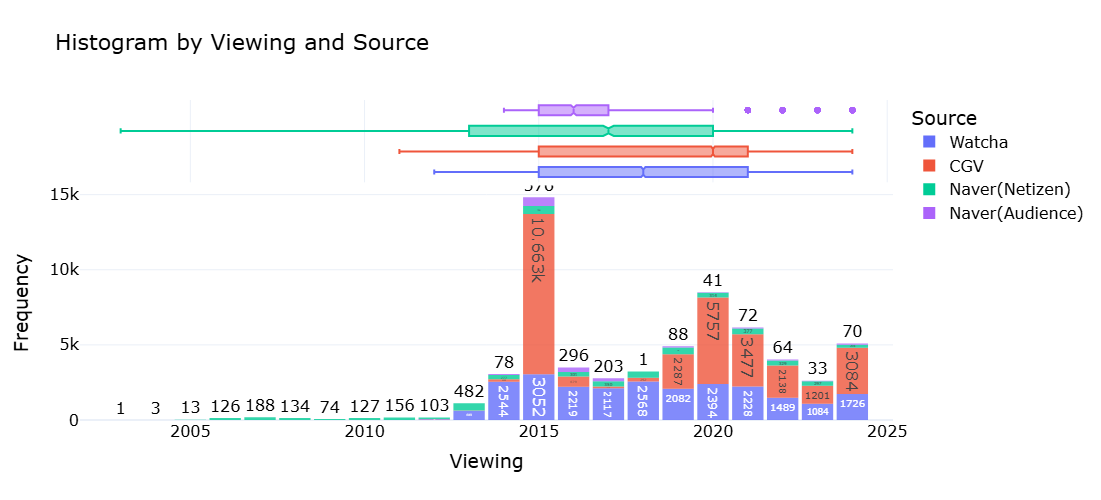

count       mean    std        min        25%        50%  \
Viewing 60,803.0000 2,018.3124 3.4260 2,003.0000 2,015.0000 2,019.0000   

               75%        max  
Viewing 2,021.0000 2,024.0000

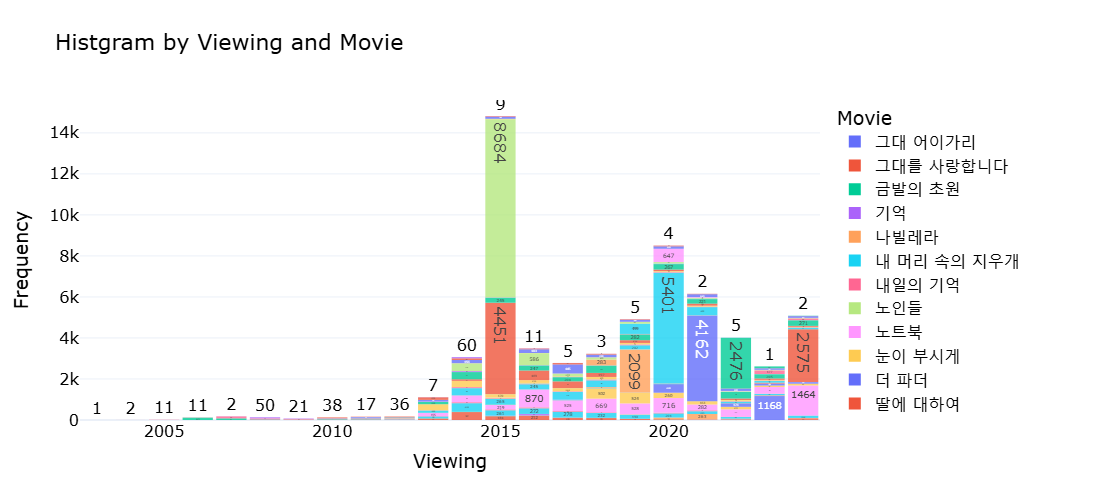

In [35]:
# 데이터 추세
## 연도별(리뷰) 소스별 리뷰의견수 추세
plot_histogram(df_result, x='Viewing', color='Source', title='Histogram by Viewing and Source', marginal='box')
## 연도별(리뷰) 영화별 리뷰의견수 추세
plot_histogram(df_result, x='Viewing', color='Movie', title='Histgram by Viewing and Movie')

count   mean     std    min    25%    50%    75%      max
Length 60,803.0000 6.6606 12.6072 1.0000 3.0000 4.0000 7.0000 952.0000

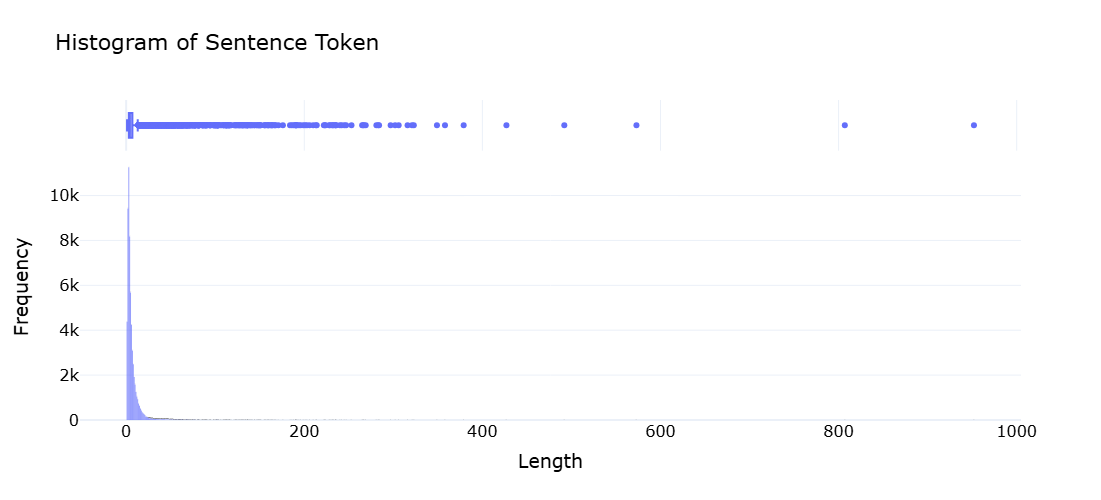

word(SoyNLP)  score(SoyNLP) word(TF-IDF)  score(TF-IDF) word(KeyBERT)  \
0            기억     5,881.0000           다시       439.0000          재미있게   
1            연기     5,074.0000           내가       435.0000           연기가   
2            사람     3,866.0000          연기가       422.0000          좋았어요   
3           마지막     3,366.0000           진짜       420.0000         잘봤습니다   
4            치매     3,092.0000         좋았어요       386.0000           재밌게   
5            가슴     2,889.0000           좋은       378.0000         영화입니다   
6            반전     2,874.0000           연기       375.0000          감동적인   
7            배우     2,783.0000          영화를       341.0000          배우들의   
8            눈물     2,641.0000           많이       341.0000      배우들의 연기가   
9            가장     2,245.0000           사랑       322.0000          아름다운   
10           현실     2,235.0000           역시       319.0000          다시봐도   
11           재미     2,226.0000         아름다운       308.0000            감동   
12          부모님     2,009.0000           없는       299.0000          영화네요   
13          드라마     1,896.0000           눈물       290.0000          오랜만에   
14           놀란     1,853.0000         재미있게       285.0000           잔잔한   
15           모습     1,811.0000           가장       273.0000           반전이   
16          스토리     1,809.0000          영화가       271.0000            딸에   
17           처음     1,727.0000           나는       271.0000           마음이   
18        알츠하이머     1,672.0000          마지막       271.0000            연기   
19          안소니     1,651.0000           감동       268.0000         감동적이고   

    score(KeyBERT)  
0              288  
1              255  
2              190  
3              173  
4              171  
5              158  
6              147  
7              142  
8              139  
9              139  
10             139  
11             132  
12             127  
13             120  
14             117  
15             115  
16             111  
17             110  
18             104  
19             101

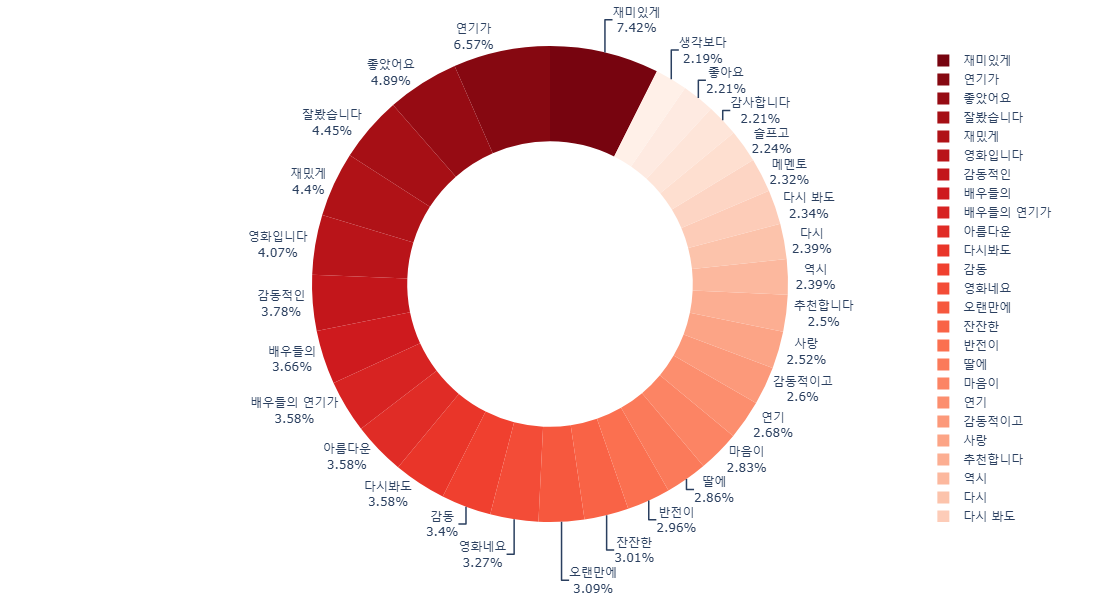

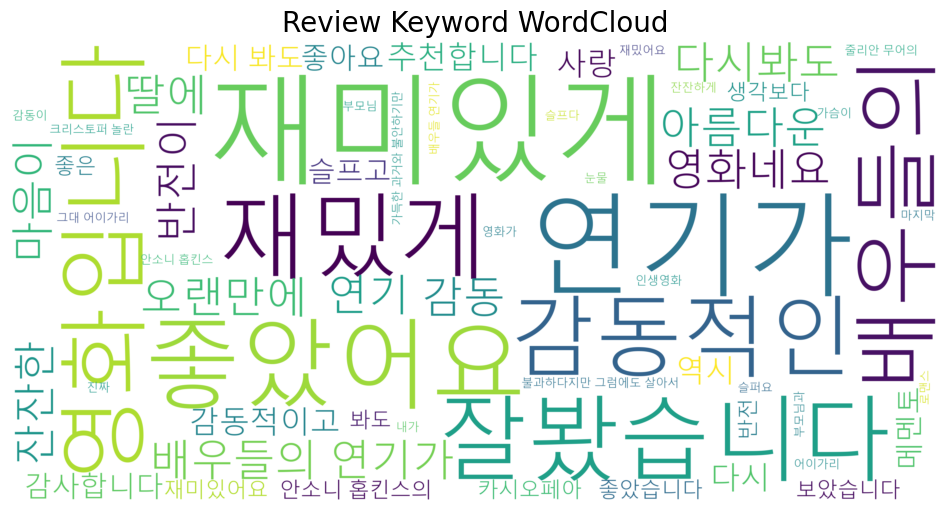

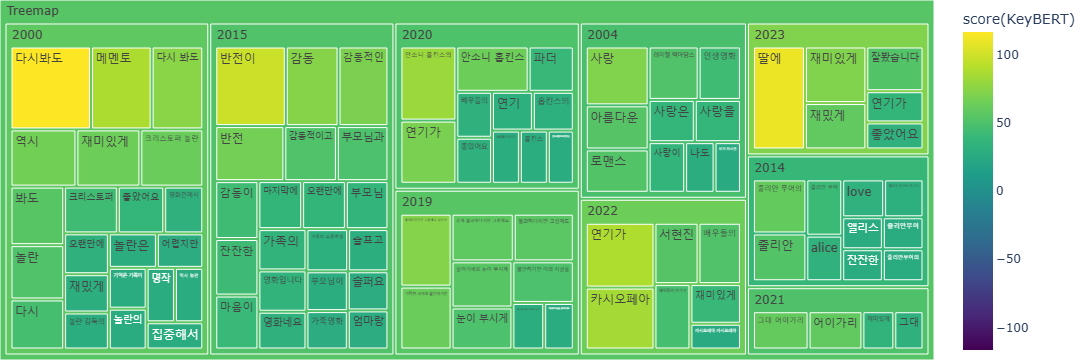

In [26]:
# 키워드 분포
## 리뷰문장 토큰 길이 분포
plot_histogram_senttoken(df_result['Token_'+TOKENIZER]) 
## 리뷰뮨장 토큰 비교
display(word_freq.head(20))
## 전체기간 주요키워드 분포
wf_colnames = [col for col in word_freq.columns if col.find(TOKENIZER) != -1]
plot_donut_wordfreq(word_freq[wf_colnames])
plot_wordcloud(word_freq[wf_colnames], title='Review Keyword WordCloud', max_font_size=50, save_local=False)
## 연도별(리뷰) 주요키워드 분포
wfc_colnames = [col for col in word_freq_categ.columns if col.find(TOKENIZER) != -1]
plot_treemap_wordfreq(word_freq_categ[wfc_colnames])

In [28]:
# 원래의견 기준 LDA 최종
NUM_TOPIC = 4
save_name = SAVE_NAME_LDA.split('.')[0]+'_CommentPrepAuto(1,3)_Topic{}.xlsx'.format(NUM_TOPIC)

topic_kw_LDA, topic_doc_LDA, \
doc_topic_LDA, model_LDA = modeling_LDA(df_freq['Token_'+TOKENIZER], df_freq['Comment_Prep'],
                                        num_topics=NUM_TOPIC, num_topicwords=NUM_TOPICWORDS, num_topicsamples=NUM_TOPICSAMPLES,
                                        save_local=SAVE_LOCAL, save_name=save_name)
display(topic_kw_LDA, topic_doc_LDA, doc_topic_LDA)

2025-02-06 22:02:53,559	INFO worker.py:1777 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\KK\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\KK\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!

KeyboardInterrupt



In [23]:
## 주제 분포
df_topic_ratio, _ = LDA_resultstat(df_result, 'Movie', 'Related Topic', colname_prefix='Topic')

Topic Rank
Movie                     
그대 어이가리              1 > 2
그대를 사랑합니다            1 > 2
금발의 초원               2 > 1
기억                   1 > 2
나빌레라                 2 > 1
내 머리 속의 지우개          1 > 2
내일의 기억               2 > 1
노인들                  2 > 1
노트북                  2 > 1
눈이 부시게               2 > 1
더 파더                 2 > 1
딸에 대하여               2 > 1
러블리, 스틸              1 > 2
레저 시커                2 > 1
로망                   1 > 2
메멘토                  1 > 2
사랑의 기적               2 > 1
살인자의 기억_복수           2 > 1
세비지스                 2 > 1
세상에서 가장 아름다운 이별      1 > 2
소중한 사람               2 > 1
스틸 앨리스               2 > 1
시                    2 > 1
어웨이 프롬 허             2 > 1
엄마의 공책               1 > 2
왓 데이 해드              2 > 1
이터널 메모리              2 > 1
장수상회                 1 > 2
조금씩, 천천히 안녕          2 > 1
천일의 약속               2 > 1
첫 키스만 50번째           2 > 1
친정엄마                 1 > 2
카시오페아                1 > 2
해피엔딩 프로젝트            2 > 1

In [8]:
## Rating 분포
df_rating_binary_ratio, _ = LDA_resultstat(df_result[df_result.Rating_Binary != 0], 'Movie', 'Rating_Binary', colname_prefix='Rating')
df_rating_multi_ratio, _ = LDA_resultstat(df_result[df_result.Rating_Multi != -1], 'Movie', 'Rating_Multi', colname_prefix='Rating')

Rating Rank
Movie                      
그대 어이가리              1 > -1
그대를 사랑합니다            1 > -1
금발의 초원               1 > -1
기억                       -1
나빌레라                     -1
내 머리 속의 지우개          -1 > 1
내일의 기억               1 > -1
노인들                      -1
노트북                  -1 > 1
눈이 부시게                   -1
더 파더                 1 > -1
딸에 대하여               1 > -1
러블리, 스틸              1 > -1
레저 시커                    -1
로망                   1 > -1
메멘토                  1 > -1
사랑의 기적               1 > -1
살인자의 기억_복수           -1 > 1
세비지스                     -1
세상에서 가장 아름다운 이별      1 > -1
소중한 사람               1 > -1
스틸 앨리스               1 > -1
시                    1 > -1
어웨이 프롬 허             1 > -1
엄마의 공책               1 > -1
왓 데이 해드              1 > -1
이터널 메모리              -1 > 1
장수상회                 -1 > 1
조금씩, 천천히 안녕          1 > -1
천일의 약속                   -1
첫 키스만 50번째           1 > -1
친정엄마                 1 > -1
카시오페아                1 > -1
해피엔딩 프로젝트            1 > -1

Rating Rank
Movie                                  
그대 어이가리              10 > 8 > 2 > 4 > 0
그대를 사랑합니다        4 > 10 > 6 > 2 > 0 > 8
금발의 초원           10 > 8 > 4 > 6 > 2 > 0
기억                        4 > 6 > 2 > 0
나빌레라                      4 > 6 > 2 > 0
내 머리 속의 지우개      4 > 6 > 10 > 2 > 0 > 8
내일의 기억               4 > 10 > 8 > 6 > 2
노인들                           4 > 6 > 2
노트북              4 > 6 > 2 > 10 > 0 > 8
눈이 부시게                    6 > 4 > 2 > 0
더 파더             4 > 10 > 6 > 8 > 2 > 0
딸에 대하여           4 > 10 > 8 > 6 > 2 > 0
러블리, 스틸              4 > 10 > 6 > 2 > 8
레저 시커                         4 > 2 > 6
로망               10 > 4 > 2 > 8 > 6 > 0
메멘토              4 > 6 > 10 > 2 > 8 > 0
사랑의 기적           4 > 10 > 6 > 8 > 2 > 0
살인자의 기억_복수           4 > 8 > 2 > 6 > 10
세비지스                          4 > 2 > 6
세상에서 가장 아름다운 이별  4 > 6 > 10 > 2 > 0 > 8
소중한 사람               10 > 4 > 8 > 2 > 6
스틸 앨리스           4 > 10 > 8 > 6 > 2 > 0
시                4 > 6 > 10 > 2 > 0 > 8
어웨이 프롬 허         4 > 10 > 8 > 6 > 2 > 0
엄마의 공책           10 > 2 > 4 > 8 > 6 > 0
왓 데이 해드              4 > 10 > 8 > 6 > 2
이터널 메모리          4 > 10 > 6 > 8 > 2 > 0
장수상회             4 > 10 > 2 > 6 > 8 > 0
조금씩, 천천히 안녕      4 > 10 > 2 > 8 > 6 > 0
천일의 약속                        4 > 6 > 2
첫 키스만 50번째       4 > 10 > 6 > 2 > 8 > 0
친정엄마             10 > 4 > 6 > 2 > 8 > 0
카시오페아            10 > 4 > 8 > 2 > 6 > 0
해피엔딩 프로젝트            10 > 4 > 8 > 6 > 2

In [9]:
## Rating의 주제에 따른 분포
df_result[df_result.Rating_Binary != 0].groupby('Related Topic')[['Rating_Binary']].value_counts().unstack()

Rating_Binary    -1     1
Related Topic            
1              1611  2336
2              1871  1878
3               701  1386
4              1010   709

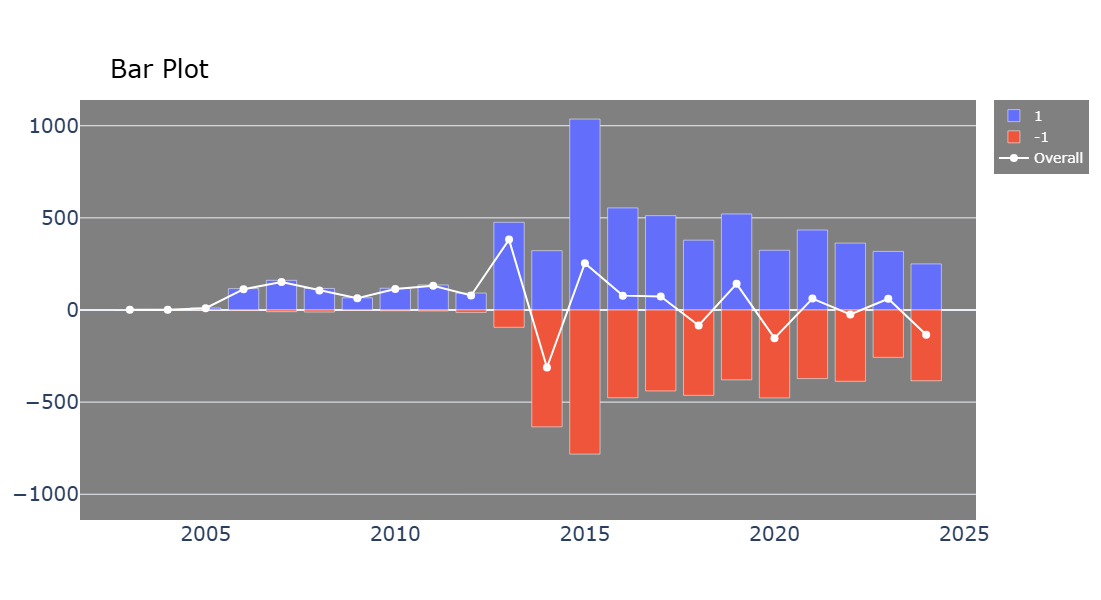

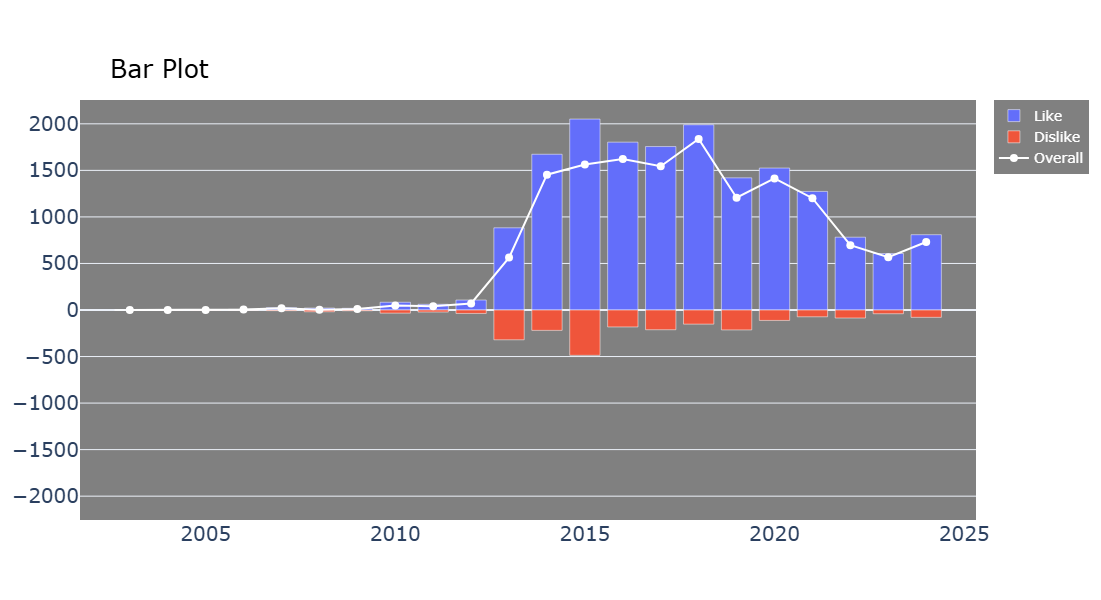

In [10]:
## 감성분석
## 리뷰연도별 평점 긍부정 트랜드
df_sent_time = df_result[df_result.Rating_Binary != 0].groupby('Viewing')[['Rating_Binary']].value_counts().unstack()
df_sent_time = df_sent_time[[1,-1]]
df_sent_time.iloc[:,1] = df_sent_time.iloc[:,1] * -1
plot_bar(df_sent_time, summation=True, save_local=False)

## 리뷰연도별 좋아요 긍부정 트랜드
df_sent_time = df_result.groupby('Viewing')[['Like', 'Dislike']].sum()
plot_bar(df_sent_time, summation=True, save_local=False)

1


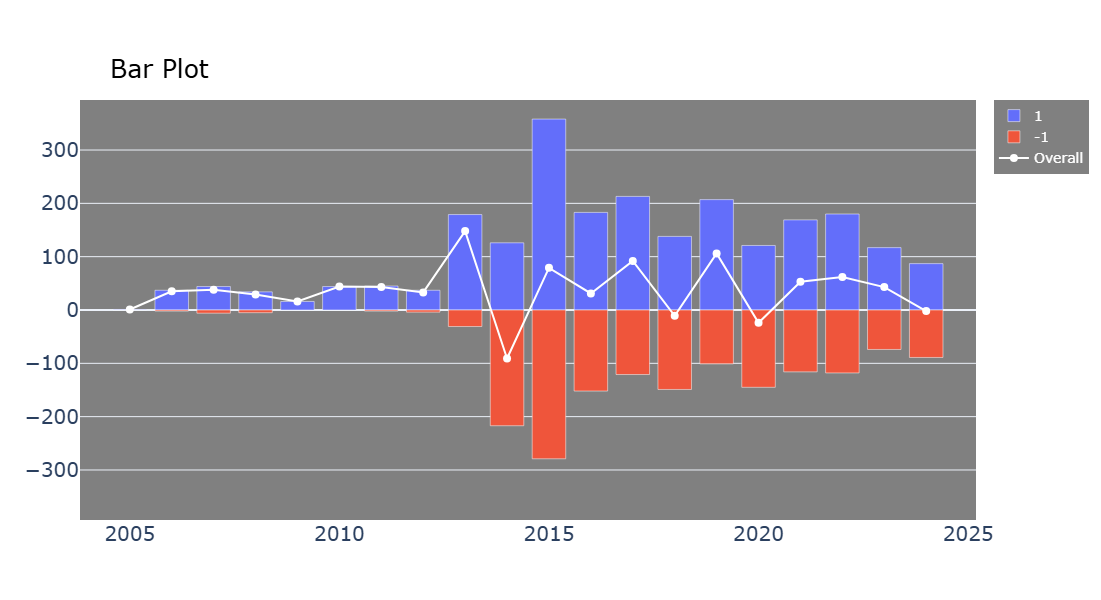

2


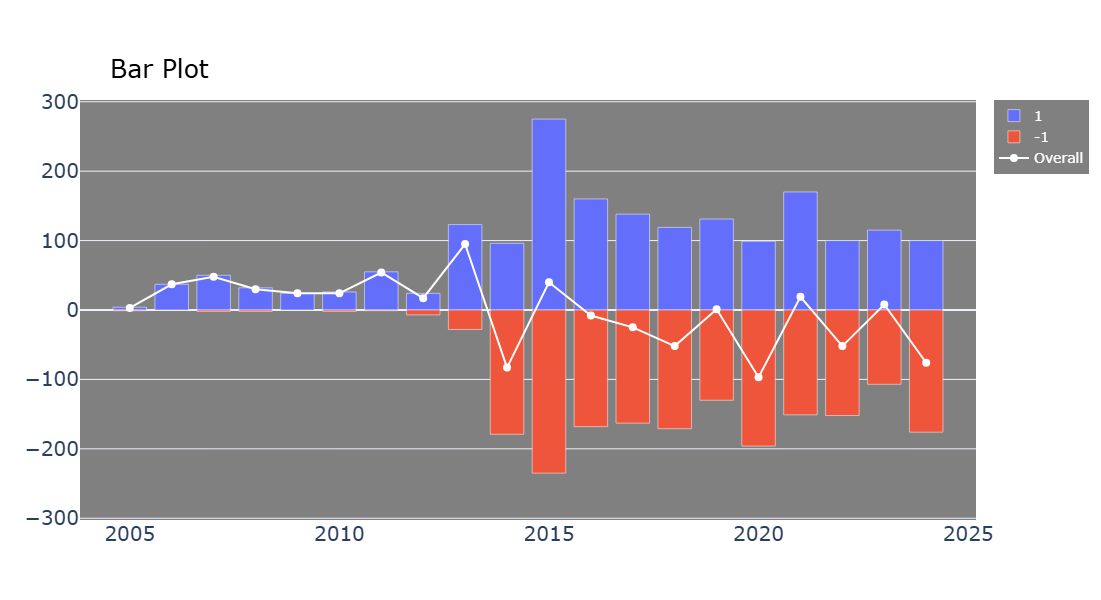

3


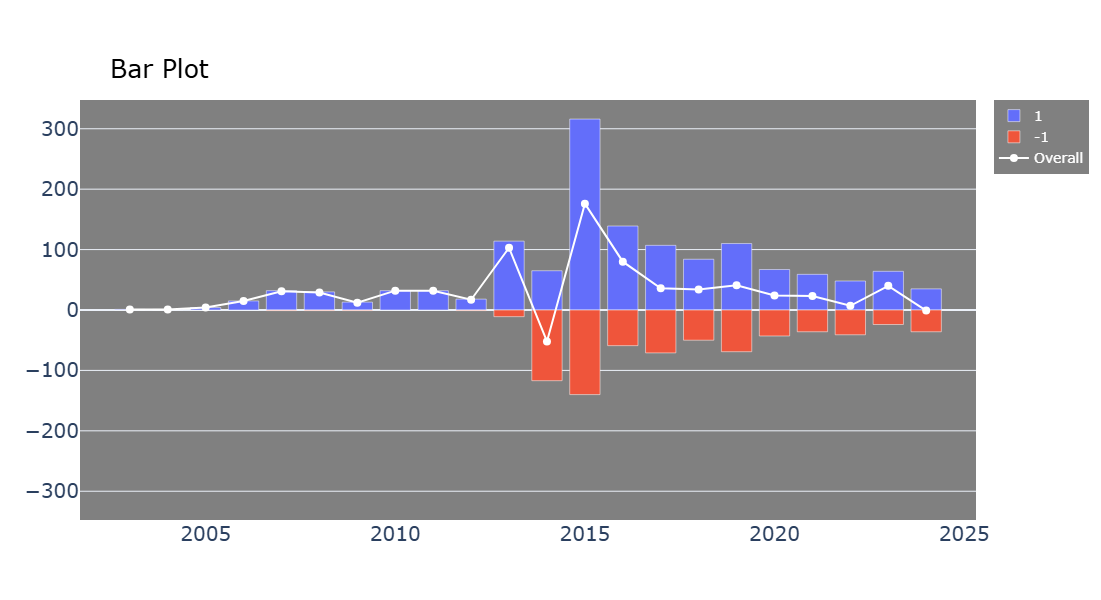

4


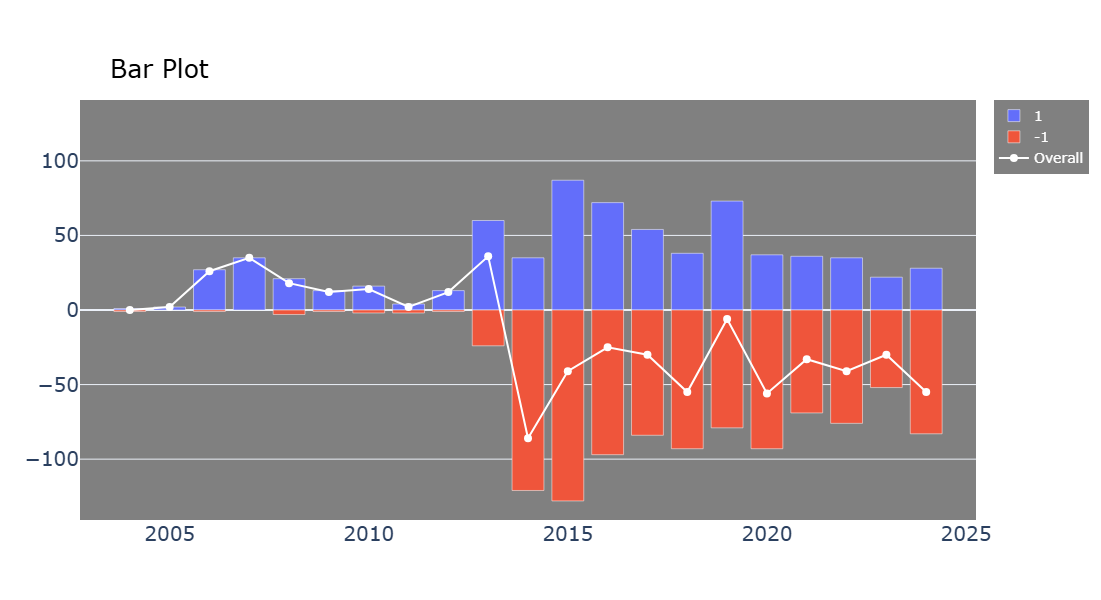

In [11]:
## 주제별 평점 긍부정 트랜드
for topic in sorted(df_result['Related Topic'].unique()):
    print(topic)
    df_sub = df_result[df_result['Related Topic'] == topic].reset_index().iloc[:,1:]
    df_sub_time = df_sub[df_sub.Rating_Binary != 0].groupby('Viewing')[['Rating_Binary']].value_counts().unstack()
    df_sub_time = df_sub_time[[1,-1]]
    df_sub_time.iloc[:,1] = df_sub_time.iloc[:,1] * -1
    plot_bar(df_sub_time, summation=True, save_local=False)

# ## 주제별 좋아요 긍부정 트랜드
# for topic in sorted(df_result['Related Topic'].unique()):
#     df_sub = df_result[df_result['Related Topic'] == topic].reset_index().iloc[:,1:]
#     df_sub_time = df_sub.groupby('Viewing')[['Like', 'Dislike']].sum()
#     plot_bar(df_sub_time, summation=True, save_local=False)

In [12]:
## 치매 주제의 평점 긍부정 트랜드
movie_filter_num = 5
for topic in sorted(df_result['Related Topic'].unique()):
    if topic == 2:
        df_sub = df_result[df_result['Related Topic'] == topic].reset_index().iloc[:,1:]
        df_group = df_sub[df_sub.Rating_Binary != 0].groupby(['Movie'])[['Rating_Binary']].sum()
        movie_posi = list(df_group[df_group>=0].dropna().index)
        movie_nega = list(df_group[df_group<0].dropna().index)
        display(df_group.loc[movie_posi,:].sort_values(by='Rating_Binary', ascending=False).T)
        display(df_group.loc[movie_nega,:].sort_values(by='Rating_Binary', ascending=False).T)
        movie_posi = list(df_group.loc[movie_posi,:].sort_values(by='Rating_Binary', ascending=False).index[:movie_filter_num])
        movie_nega = list(df_group.loc[movie_nega,:].sort_values(by='Rating_Binary', ascending=False).index[-movie_filter_num:])
        print(movie_posi, movie_nega)

Movie          더 파더  메멘토  금발의 초원  사랑의 기적  내일의 기억  로망  어웨이 프롬 허   시  그대 어이가리  \
Rating_Binary   104   70      66      45      45  43        36  32       31   

Movie          스틸 앨리스  친정엄마  카시오페아  그대를 사랑합니다  해피엔딩 프로젝트  소중한 사람  딸에 대하여  \
Rating_Binary      28    28     27         25         23      22      18   

Movie          러블리, 스틸  엄마의 공책  왓 데이 해드  
Rating_Binary        9       7        0

Movie          노인들  세비지스  천일의 약속  기억  레저 시커  살인자의 기억_복수  첫 키스만 50번째  이터널 메모리  \
Rating_Binary   -2    -3      -3  -4     -5          -5          -5       -7   

Movie          나빌레라  조금씩, 천천히 안녕  세상에서 가장 아름다운 이별  눈이 부시게  장수상회  내 머리 속의 지우개  \
Rating_Binary   -10          -20              -23     -33   -91         -123   

Movie          노트북  
Rating_Binary -318

['더 파더', '메멘토', '금발의 초원', '사랑의 기적', '내일의 기억'] ['세상에서 가장 아름다운 이별', '눈이 부시게', '장수상회', '내 머리 속의 지우개', '노트북']


In [13]:
## 감성에 따른 데이터분리
df_result_posi = df_result[df_result.Movie.isin(movie_posi)]
df_result_posi = df_result_posi[df_result_posi.Rating_Binary == 1].reset_index().iloc[:,1:]
df_result_nega = df_result[df_result.Movie.isin(movie_nega)]
df_result_nega = df_result_nega[df_result_nega.Rating_Binary == -1].reset_index().iloc[:,1:]

In [15]:
## 긍정영화 LDA 주제어
NUM_TOPIC = 3
save_name = SAVE_NAME_LDA.split('.')[0]+'_CommentPrepAuto(1,3)_SentiPosi_Topic{}.xlsx'.format(NUM_TOPIC)

topic_kw_LDA, topic_doc_LDA, \
doc_topic_LDA, model_LDA = modeling_LDA(df_result_posi['Token_'+TOKENIZER], df_result_posi['Comment_Prep'],
                                        num_topics=NUM_TOPIC, num_topicwords=NUM_TOPICWORDS, num_topicsamples=NUM_TOPICSAMPLES,
                                        save_local=SAVE_LOCAL, save_name=save_name)
display(topic_kw_LDA, topic_doc_LDA)

## 부정영화 LDA 주제어
NUM_TOPIC = 3
save_name = SAVE_NAME_LDA.split('.')[0]+'_CommentPrepAuto(1,3)_SentiNega_Topic{}.xlsx'.format(NUM_TOPIC)

topic_kw_LDA, topic_doc_LDA, \
doc_topic_LDA, model_LDA = modeling_LDA(df_result_nega['Token_'+TOKENIZER], df_result_nega['Comment_Prep'],
                                        num_topics=NUM_TOPIC, num_topicwords=NUM_TOPICWORDS, num_topicsamples=NUM_TOPICSAMPLES,
                                        save_local=SAVE_LOCAL, save_name=save_name)
display(topic_kw_LDA, topic_doc_LDA)

[Kss]: too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy


Related Keywords  \
Topic 1  '놀란(18.7%)', '생각(9.9%)', '최고(9.9%)', '치매(9.9%)', '현실(9.9%)', '마지막(8.8%)', '감동(8.8%)', '눈물(8.8%)'...   
Topic 2  '연기(15.9%)', '안소니(13.6%)', '좋은(12.5%)', '진짜(11.4%)', '내가(9.1%)', '작품(8.0%)', '기억(8.0%)', '감동(8.0...   
Topic 3  '연기(29.4%)', '기억(10.9%)', '감동(10.1%)', '안소니(9.2%)', '최고(8.4%)', '이야기(7.6%)', '치매(6.7%)', '홉킨스의(5...   

         Number of Sentences  Percentage  
Topic 1                  485      0.3363  
Topic 2                  441      0.3058  
Topic 3                  516      0.3578

Topic Number  Weight  \
971       Topic 1  0.9693   
556       Topic 1  0.9681   
604       Topic 1  0.9678   
550       Topic 1  0.9664   
694       Topic 1  0.9645   
696       Topic 2  0.9684   
595       Topic 2  0.9658   
1014      Topic 2  0.9651   
580       Topic 2  0.9650   
1356      Topic 2  0.9642   
527       Topic 3  0.9729   
613       Topic 3  0.9711   
985       Topic 3  0.9705   
629       Topic 3  0.9698   
1030      Topic 3  0.9693   

                                                                                             Comment_Prep  
971   전개을 주인공이 바라보는 시점으로 이끌고 가다 보니 관객들 역시 전개 내내 어떤스토리가 진짜인지 누가 범인인지 종잡을수 없게 만든다 추리 자체가 불가능한 기억 상실이라는 소...  
556   치매 노인의 혼돈을 vr을 쓰고 경험한듯  차마 노인들에게는 관람을 권하지 못할  무너져내리는 인간 존엄성의 한끝에 필사적으로 매달리다 무너져내린 슬픈 아버지의 모습을 일말...  
604   나도 나이를 먹으면 문을지나야할텐데 부모님에대한생각 자식들에관한생각 나스스로에 생각 인생의 황혼이라는 시간에대한 생각 많은것을 생각하게 하네요 100점 만점의 120점 극찬...  
550   부모님에 여러가지 복잡한 생각과 자신에 대해서도 돌아보게 되는 영화입니다 모두는 늙어갈 수밖에 없는 연약한 존재이기 때문에제가 지금까지 본 영화중에 가장 영혼의 울림을 주는...  
694   마음이 울컥해지는 로라라고 간병인이 루시를 닮았다 했을때 앤이 우나 했는데 나중에 요양원에서 아빠란 소리를 듣고 따라가보니 사고를 당한 피투성이 루시가 누워있었다는 치매에 ...  
696   안소니의 혼란을 그대로 느낄 있습니다 영화를 보면서 혼란과 공포스런 마음이 내가 겪은것처럼 생생합니다 나도 모르게 눈물을 줄줄 흘리면서 본 작품이에요 수작이고 안소니 홉킨스...  
595   누구도 믿지 못하게 되는 공포 시공간이 뒤틀리는 경험의 공포 자신의 기억과 보여지는 현상 사이의 괴리에서 느껴지는 공포 더이상 일이 벌어지고 있는지 모르겠다는 눈물의 고백을...  
1014  역순으로 보여주는 연출이 관객까지 사건의 진실을 파헤치는 동조하게 만든다 주인공도 매력적이다 테디 아저씨 의심해서 미안해요 하나의 john g를 만들어내 쫓으려는 레니의 선...  
580   영화를 나니 치매가 두렵다 요양원인지 요양병원인지 칠순이 넘으신 나의 아빠는 지금도 연세에 비해 무척 건강하시지만 내가 어렸던 아주 오래 전부터 지금까지 곳에 부모를 보내는...  
1356  초반 스따뚜 지루지루일요아침드라마 같은 편안한느낌근데 3분의1지나면 재밌음 시작 전개 도입부분 집중력요함 후반에 아이러니한게 환자를 치료해도 오랫동안 환자였던 그들이 다시 ...  
527   k신파처럼 울라고 꼬집지 않았는데 끝에 안소니가 무너지는 모습 혼란스러워하는 모습 왈칵 감독이 치매를 겪어본것도 아닌데 치매 환자 머릿속에 들어가서 내가 치매환자가 된 기분...  
613   시간이 흐름에 우리에게 다가오는 노년기 어쩌면 내가 겪게 될지도 모른다는 점에서 섬뜩하고 마음이 아프다 가족이 감내해야하는 고통에 여러매체나 주변에서도 답습했기에 다가오는 ...  
985   초반에는 이게 뭔가싶었는데 지나서야 이야기의 형태를 이해 했음 솔직히 초반엔 지루했다 근데 갈수록 이야기의 진실이 궁금해졌고 집중하고 몰입하게 됨 보다보면 주인공처럼 기억단...  
629   퍼즐이라면 어렵게라도 맞추면 되지만기억과 시간과 장소가 파편화 되어버렸는데 이걸 다시 맞출까시종일관 치매당사자가 내가 되었다가 다시 치매가족이 될 있도록 연출하고 연기한 것...  
1030  타임라인을 뒤죽박죽은 아니고 거꾸로 나열해놨는지 결말을 보면 듯 소름끼치고 무서움 갑툭튀 쩌는 공포 영화들보다 무섭고 하필이면 밤중에 봐서 혹여나 꿈에 나올까 걱정되기도 이...

[Kss]: too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy


Related Keywords  \
Topic 1  '사랑(34.5%)', '감동(10.0%)', '신파(8.2%)', '연기(7.3%)', '이야기(7.3%)', '하지(7.3%)', '로맨스(7.3%)', '가족(7.3%...   
Topic 2  '반전(23.0%)', '엄마(15.0%)', '사랑(13.0%)', '눈물(10.0%)', '배우들(9.0%)', '슬픈(6.0%)', '감동(6.0%)', '영화가(6....   
Topic 3  '눈물(15.5%)', '스토리(13.6%)', '뻔한(12.7%)', '하다(10.0%)', '이야기(9.1%)', '연기(9.1%)', '신파(8.2%)', '좋은(7....   

         Number of Sentences  Percentage  
Topic 1                 1293      0.4361  
Topic 2                  738      0.2489  
Topic 3                  934      0.3150

Topic Number  Weight  \
1042      Topic 1  0.9890   
636       Topic 1  0.9860   
1599      Topic 1  0.9855   
678       Topic 1  0.9854   
1670      Topic 1  0.9853   
1874      Topic 2  0.9830   
973       Topic 2  0.9675   
1879      Topic 2  0.9605   
294       Topic 2  0.9576   
2064      Topic 2  0.9569   
376       Topic 3  0.9764   
97        Topic 3  0.9743   
824       Topic 3  0.9700   
757       Topic 3  0.9690   
106       Topic 3  0.9689   

                                                                                             Comment_Prep  
1042  사랑 여름 앨리를 놓쳐버린 노아가 바보같았다 저렇게 사랑스러운 여자를 목숨을 걸고서라도 가서 잡았어야지 보내주다니 노아에겐 더이상 자격이 없다고 생각했고 론과 걱정없는 사랑...  
636   운명적 사랑을 대신할 조건은 우리가 크고 작은 사랑을 있다는 전제가 아닌 지금 마주보고 사람에 흔들림 없는 태도       떨어져 있어도 서로만을 생각하고 편지를 뺏어가도 ...  
1599  솔직히 유명한지 모르겠다 보면서 나만 론 입장 생각한건가 분명 주인공들 입장에서야 첫사랑이고 늙을 때까지 변함 없는 사랑이겠지만 론 입장에서는 결혼식 앞두고 예비신부가 첫사...  
678   영화는 기본적으로 허구에 기반하고 허구가 아니라고 하더라고 허구처럼 드라마틱 해야 영화의 소재가 된다 첫사랑이 많은 고통을 통해서 이루어 지고 사랑하는 사람과 한날 한시에 ...  
1670  로맨스영화 순위에 늘 높게 올라 있어서 이번에 잡고 본건데 내가 남자랑 엮인 경험이 없어서 그런건지 어떤건지 영화가 인생 영화라는 사람들은 절절한 감정을 겪고 불같은 사랑을...  
1874  요리를 위해 재료를 정성껏 예쁘게 다듬어 놓고선 모아 대강  잡탕 찌개를 끓여낸 재료 본연의 맛으로 어찌저찌 맛은 있지만  재료를 어여쁘게 다듬었던 시간은 별 의미가 없어졌...  
973   최악의 영화친구들이 인생영화라고 극찬해서 봤는데 최악이였다맥락이 이해가 안되고 노아랑 앨리 다 극혐론만 좋았던 영화가난하고 지저분하고 자유분방한 사랑은 진짜 내취향 아닌 거...  
1879  김혜자 연기 봐서 영광 안내상도 다리 절 때마다 눈물나게 이정은은 말할것도 중간 중간 띠용하게 오버가 있었지만 엔딩 나레이션 듣고 다 날아감 노인 주연에 노인 문제 다루는 ...  
294   손예진은 푸른 녹음 아래 가장 예쁘다 청매실 풋사과 같은 싱그러움 여름향기 손예진도 같은 느낌이고 예뻐  병신같은 남자 취향인 적극적인 부잣집공주님  말도 안되는 이야긴가 ...  
2064  1 박하선 연기 슬펐다 2 와이프가 죽고 엄마가 죽는다는데 가족 구성원이 보인 태도 슬펐다엄마가 죽는다는데 박하선이 야밤에 사진 보면서 차나 마시면서 감상에 젖는 씬 김갑수...  
376   평점도 높고 그렇게 슬프다길래 오랜만에 울어보고 싶어서 휴지까지 준비했다 그렇게 영화를 보는데 부분에서 울어야 할지 도무지 알수 없었다  내 감정이 이토록 메말라버린것인가 ...  
97    담백하게 보기 좋다 치매나 불치병을 다룬 수많은 로맨스영화들이 그러하듯 병의 추악하고 더러운 밑바닥까지 나타낼 수는 않는다 주연들의 연기 덕에 매끄럽게 몰입해서 보기 좋았다...  
824   앨리에게 버려진 남자 노아에게 이용당하고 버려진 여자 끔찍하다 주인공 둘만 행복하면 장땡 어처구니가 없네 남들에게 씻지못할 상처를 주고 아무렇지 않게 자기들만의 로맨스를 즐...  
757   영화를 처음 봤을 시작하고 분만에 꺼버렸더랬다 내 스타일 아니라서 재개봉 소식에 볼까 싶어서 알아봤지만 영화를 고르는 내 안목은 역시 틀린게 아니었구나 싶다 영화는 앞으로도...  
106   예진언니는 이때도 연기를 잘했구나 어린 시절에 봤을때는 이쁜언니라고 생각했는데 연기가 뒷받침되어서 예쁘다는걸 느낄 있었던거군 분위기도 좋고 영상미도 예쁜영화였네  이시절들의...

In [ ]:
# Hyperparameters
TASK = 'text-classification'
# MODEL_NAME = 'kykim/bert-kor-base'
MODEL_NAME = 'beomi/kcbert-base'
NUM_LABELS = 2
RETURN_ALL_SCORES = False
EPOCHS = 2
BATCH = 64
STRATEGY = 'epoch'
if STRATEGY == 'epoch':
    LOAD_BMAE = False
else:
    LOAD_BMAE = True

# Data Loading
dataset = load_dataset('sepidmnorozy/Korean_sentiment')

# Preprocessing
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def apply_tokenizer(x):
    return tokenizer(x['text'], padding='max_length', max_length=256, truncation=True)

dataset_tokenized = dataset.map(apply_tokenizer, batched=True)
train = dataset_tokenized['train'].shuffle(seed=42).select(range(1000))
validation = dataset_tokenized['validation']
test = dataset_tokenized['test']

# Modeling
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS)

training_args = TrainingArguments(output_dir='outputs', 
                                  num_train_epochs=EPOCHS, per_device_train_batch_size=BATCH, per_gpu_eval_batch_size=BATCH,
                                  logging_strategy=STRATEGY, logging_steps=100, 
                                  evaluation_strategy=STRATEGY, eval_steps=100, 
                                  learning_rate=1e-4, weight_decay=0.01,
                                  gradient_accumulation_steps=4,
                                  load_best_model_at_end=LOAD_BMAE, 
                                  metric_for_best_model='accuracy', greater_is_better=True,
                                  disable_tqdm=False, fp16=True)

def compute_metrics(eval_pred):
    # evaluate.list_evaluation_modules()
    f1 = evaluate.load('f1')
    accuracy = evaluate.load('accuracy')

    predictions, label_ids = eval_pred.predictions, eval_pred.label_ids
	# predictions = predictions.argmax(axis=1)
    predictions = np.argmax(predictions, axis=-1)
    metric_f1 = f1.compute(predictions=predictions, references=label_ids, average="weighted")
    metric_accuracy = accuracy.compute(predictions=predictions, references=label_ids)
	
    return metric_f1, metric_accuracy
    
trainer = Trainer(model=model, compute_metrics=compute_metrics, 
                  tokenizer=tokenizer, train_dataset=train, eval_dataset=validation, 
                  args=training_args)
trainer.train()
# model_pipeline = pipeline(task=TASK, model=model, tokenizer=tokenizer, 
#                           return_all_scores=RETURN_ALL_SCORES, truncation=True)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at beomi/kcbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [40]:
df_result_val = df_result[df_result.Rating_Binary != 0]
sentiment = df_result_val.Comment.progress_apply(model_pipeline)


100%|█████████████████████████████████████████████████████████████████████████████| 11502/11502 [06:25<00:00, 29.83it/s]


In [41]:
Y_pred = sentiment.apply(lambda x: x[0]['label'][-1])
# Y_pred = Y_pred.apply(lambda x: -1 if x >= 1 else 1)
Y_pred.value_counts()



Comment
1    7642
0    3860
Name: count, dtype: int64

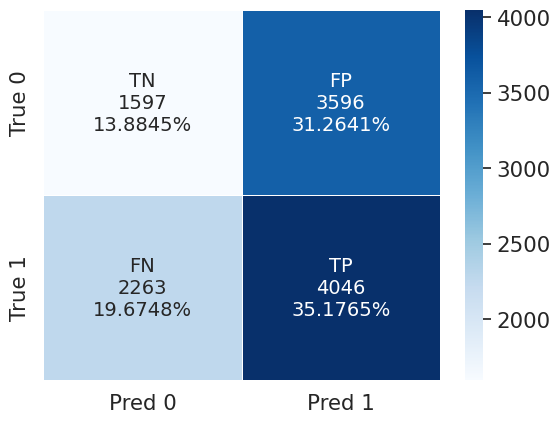

Pred 0  Pred 1
True 0    1597    3596
True 1    2263    4046

In [51]:
evaluation_class_ConfusionMatrix(df_result_val.Rating_Binary.apply(lambda x: 0 if x == -1 else 1), Y_pred.astype('int'))

## BERTopic

In [11]:
# # 원래의견 기준 BERTopic
# save_name = SAVE_NAME_BERTopic.split('.')[0]+'_CommentAuto(1,2).xlsx'
# NUM_TOPICS_BERT = topic_kw_LDA.shape[0]

# topic_kw_BERT, topic_doc_BERT, \
# doc_topic_BERT, model_BERT = modeling_BERTopic(df_freq['Comment'], vectorizer_type='tfidf', 
#                                                ngram_range=NGRAM_RANGE,
#                                                tfidf_maxcol=TFIDF_MAXCOL, 
#                                                # umap_metric=UMAP_METRIC, umap_randomseed=UMAP_SEED,
#                                                num_topics=NUM_TOPICS_BERT, num_topicwords=NUM_TOPICWORDS, num_topicsamples=NUM_TOPICSAMPLES,
#                                                save_local=SAVE_LOCAL, save_name=save_name)
# display(topic_kw_BERT, topic_doc_BERT, doc_topic_BERT)

In [12]:
# # 토픽 유사성 구조 시각화
# model_BERT.visualize_topics()

In [13]:
# # Topic 별 Hierarchy를 출력하여 대략적 Topic의 갯수를 가늠하기 용이함
# model_BERT.visualize_hierarchy(top_n_topics=50)

In [14]:
# # Topic을 대표하는 상위 단어 5개씩 출력
# model_BERT.visualize_barchart(top_n_topics=50)

In [15]:
# # Topic간 유사도를 Cosine Similarity로 계산후 Heatmap으로 표현
# model_BERT.visualize_heatmap()

In [16]:
# # 일자별로 어떤 토픽이 증가하고 줄어들었는지 트랜드 파악
# topics_over_time = model_BERT.topics_over_time(docs=df['Comment'], timestamps=df.Date.to_list(), 
#                                                global_tuning=True, evolution_tuning=True)
# model_BERT.visualize_topics_over_time(topics_over_time, top_n_topics=50)

In [17]:
# # Topic내 대표하는 단어들에 대해서 c-tf-idf로 계산해서 각 단어가 Topic에서 차지하는 중요도를 계산했던 것을 Rank 순서대로 출력
# model_BERT.visualize_term_rank()